In [132]:
%cd /content
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
#udemy_folder = "/content/drive/MyDrive/0_MAESTRIA/1_TEXT/TM_udemy_reviews"
#!cp {udemy_folder}/udemy_reviews.zip udemy_reviews.zip
%cd /content/drive/MyDrive/0_MAESTRIA/1_TEXT/TM_udemy_reviews
!ls
udemy_folder = "."


/content
Mounted at /content/drive
/content/drive/MyDrive/0_MAESTRIA/1_TEXT/TM_udemy_reviews
'!anac.bat'
 dictionary.dict
 heatmap.png
'!jupy.bat'
 LICENSE
 model
 model.zip
 Palabras_destacadas_log_odds_ratio.ipynb
 README.md
 TP4_1_topic_group.ipynb
 TP4_2_topic_group.ipynb
 TP4_topic_group_pos_neg_analisis.ipynb
 udemy_reviews_aggregated.csv.zip
 udemy_reviews_dominant.csv.zip
 udemy_reviews_with_topics.csv.zip
 udemy_reviews.zip


#### Load the libraries

In [133]:
!pip3 install -q -U spacy
!python3 -m spacy download es_core_news_md

     |████████████████████████████████| 43.4 MB 1.2 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_md')


In [134]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', None)
pd.options.display.float_format = "{:,.2f}".format

### Connect to drive to get the data

In [135]:
df_udemy = pd.read_csv(f'udemy_reviews.zip', compression='zip', header=0, sep=',', quotechar='"')
df_udemy.head()

,id,course,rating,comment,user
0,73015398,1640654,2.50,como introducción esta bien pero deberían de hacerlo mas dirigido a RPA con fotos de RPAS,Jorge Alejandro Castillo
1,50586814,1640654,4.50,Los conocimientos son claros y concisos para lo requerido,Jaime Medina
2,49880684,1640654,5.00,hermoso,Adrián Antonio Herrera Castro
3,47366486,1640654,5.00,Excelente !!!,Márcio Maurício Soares do Nascimento
4,79933910,88380,5.00,Excelente todo!,Emilio Monarrez Hernandez


In [136]:
df_news = df_udemy

In [137]:
# Aplica pos/neg
df_news['tag']=df_news['rating'].apply(lambda x: 'pos' if x >= 4 else 'neg')
# Filtra los que solamente dicen una palabra (ej. "Excelente!")
#df_news = df_news[df_news['comment'].str.contains("\s")]
# Filtra los que tienen menos de 5 palabras
df_news = df_news[df_news['comment'].str.split().str.len().gt(4)]
# Filtra los que dicen menos de 12 letras (ej. "Excelente!")
df_news = df_news[df_news['comment'].str.len() >= 12]
df_news = df_news[df_news['tag']=='neg']#.sample(2000)

df_news.reset_index(inplace=True)
display(df_news.sample(10))

# Recomendación:
# usar los comentarios con >=5 palabras


,index,id,course,rating,comment,user,tag
16757,155617,8361684,81450,3.00,el curso es exelente ...!! soy yo el que devo repetir los videos y memorizar bien todo .. hasta entonces .. todo sera lo maximo..!!,Jose Abel Ruales,neg
8180,74124,60324614,1549392,3.00,"Es un curso bastante básico para alguien que tiene algo de conocimientos sobre Importación y Alibaba. Yo no recomiendo hacer una importación de China sabiendo solo lo que explica en los videos. Hace falta muchisíma información adicional, mayores ejemplos sobre obtención de información y realización de un pedido. \nEn fin, si no tienes idea, creo que esta bueno que lo hagas. Pero, si tienes idea y quieres profundizar más, no lo recomiendo. Es muy básico.",Eduard Trama,neg
13785,125796,50131192,1317138,3.00,Pues creo que mucho rollo hasta ahorita,Julio Cesar,neg
11714,105226,34748882,976214,3.50,"Es una buena elección pero el profesor se enreda en sus propios conceptos y al hablar se le traba la lengua. Lo cual no quiere decir que sea malo o que no sepa, por el contrario es un aspecto a mejorar.",Diego Contador,neg
5941,54455,52036992,1303888,2.50,"me gusto la enseñanza, su contenido y desarrollo, mi unica observacion es que me parece que esta incompleto, al menos la segunda seccion, no trae un solo cuestionario ni examen final de seccion. Gracias!",Bertha Figueroa,neg
12180,110378,12705158,177470,2.50,"Me quedo con varias dudas entre ellas si se puede personalizar los estilos de la página (colores, tipografías,etc.)",Florencia Reyes,neg
6371,58521,7946976,917328,3.00,Me agrada como imparte los videos\n\n,Omar Muñiz,neg
3781,34873,82827316,943626,3.00,el tipo de exposición es muy rápido,Carlos Alvarez,neg
7591,68835,37629154,1648200,3.50,"demasiados epígrafes y extenso. me gustaría un resumen más sencillo. sería más útil a pocos días del examen. dificulta también no tenerlo en papel. \nEstoy tardando muchísimo en pasar a papel, no sé si es posible me envíe pdf.\nGracias.",Nila María,neg
2600,23456,87731404,1693336,1.00,"Decepcionante, está muy por debajo de mis expectativas. Fue una muy mala eleccion, nisiquiera lo vi mas del 5% porque la verdad el aburrido. Si udemy me permite transferirlo lo haria.",Carlos Garcia Quintero,neg


In [138]:
!pip install -q --upgrade gensim
import gensim
gensim.__version__

'4.1.2'

In [139]:
import numpy as np
import re
import nltk
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from nltk.corpus import stopwords
import string
import matplotlib.pyplot as plt
import gensim
import numpy as np
from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel
from gensim.corpora import Dictionary
# from gensim.models.wrappers import LdaMallet


In [140]:
df_news['tag'].value_counts()

neg    18883
Name: tag, dtype: int64

In [141]:
df_news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18883 entries, 0 to 18882
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   index    18883 non-null  int64  
 1   id       18883 non-null  int64  
 2   course   18883 non-null  int64  
 3   rating   18883 non-null  float64
 4   comment  18883 non-null  object 
 5   user     18882 non-null  object 
 6   tag      18883 non-null  object 
dtypes: float64(1), int64(3), object(3)
memory usage: 1.0+ MB


#Data Preprocessing

We defined a list of custom words to be exclude from our dataset

Create the cleaner function to clean the spanish text, remove non alpha numeric characters, remove duplicate, remove spanish accutes, remove digits

In [142]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

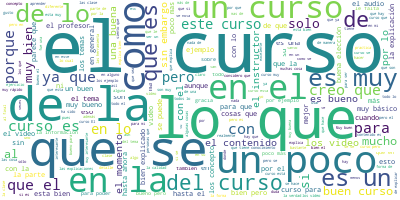

In [143]:
# Import the wordcloud library
from wordcloud import WordCloud
# Join the different processed titles together.
long_string = ','.join(list(df_news['comment'].values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()


In [144]:
from nltk import word_tokenize
from nltk.corpus import stopwords
stop = set(stopwords.words('spanish'))

black_list = ['excelente', 'buen','bien','aunque',
              'muchas', 'gracias', 'curso','course','good'
              ]

additional_stopwords=set(black_list)

stopwords_sp = stop.union(additional_stopwords)

from nltk.stem import SnowballStemmer
spanish_stemmer = SnowballStemmer('spanish')
def stemmization(texts):
    texts = re.sub(r"""
                   [,.;@#?!&$]+  # Accept one or more copies of punctuation
                   \ *           # plus zero or more copies of a space,
                   """,
                   " ",          # and replace it with a single space
                   texts, flags=re.VERBOSE)
    return spanish_stemmer.stem(texts).split()


import spacy
nlp = spacy.load('es_core_news_md')
def lemmatization(texts, allowed_postags=['NOUN']):
    #x = nlp(texts)
    #print([(xx.text,xx.pos_) for xx in x])
    texts_out = [ token.text for token in nlp(texts) if token.pos_ in 
                 allowed_postags and token.text not in black_list and len(token.text)>2]
    return texts_out

In [145]:
%%time
bigram = gensim.models.Phrases(df_news['comment'].to_list()) 

CPU times: user 2.98 s, sys: 9.87 ms, total: 2.99 s
Wall time: 2.99 s


In [146]:
def cleaner(word):
    word = re.sub(r'((http|https)\:\/\/)?[a-zA-Z0-9\.\/\?\:@\-_=#]+\.([a-zA-Z]){2,6}([a-zA-Z0-9\.\&\/\?\:@\-_=#])*', '', word, flags=re.MULTILINE)
    word = re.sub(r'(?::|;|=)(?:-)?(?:\)|\(|D|P)', "", word)
    word = re.sub(r'ee.uu', 'eeuu', word)
    word = re.sub(r'\#\.', '', word)
    word = re.sub(r'\n', '', word)
    word = re.sub(r',', ' ', word)
    word = re.sub(r'\-', ' ', word)
    word = re.sub(r'\.{3}', ' ', word)
    word = re.sub(r'a{2,}', 'a', word)
    word = re.sub(r'é{2,}', 'é', word)
    word = re.sub(r'i{2,}', 'i', word)
    word = re.sub(r'ja{2,}', 'ja', word) 
    word = re.sub(r'á', 'a', word)
    word = re.sub(r'é', 'e', word)
    word = re.sub(r'í', 'i', word)
    word = re.sub(r'ó', 'o', word)
    word = re.sub(r'ú', 'u', word)  
    word = re.sub('[^a-zA-Z]', ' ', word)
    wordlist = [ token for token in nltk.word_tokenize(word) if token.lower() not in stopwords_sp and len(token)>3 ]
    wordlist = [x for x in wordlist if not any(string for string in black_list if string in x)]
    word = " ".join(wordlist)
    list_word_clean = []
    for w1 in word.split(r"\s"):
        if  w1.lower() not in stopwords_sp:
            list_word_clean.append(w1.lower())

    bigram_list = bigram[list_word_clean]
    out_text = stemmization(" ".join(bigram_list))
    return out_text

In [147]:
cleaner('Curso. Gracias amigo me adentraste e informaste como publicar mejor en Facebook Ads , recomendación mejora tu dicción	')

['amigo',
 'adentraste',
 'informaste',
 'publicar',
 'mejor',
 'facebook',
 'recomendacion',
 'mejora',
 'diccion']

Create the function for select **only nouns** for our data, this way we are removing adverb, adjetives, verbs, etc. This is doing with spacy

For gensim we need a list of text, so we need do convert the dataframe to list

In [148]:
stemmization('Curso. Gracias amigo me adentraste e informaste como publicar mejor en Facebook Ads , recomendación mejora tu dicción')

['curso',
 'gracias',
 'amigo',
 'me',
 'adentraste',
 'e',
 'informaste',
 'como',
 'publicar',
 'mejor',
 'en',
 'facebook',
 'ads',
 'recomendacion',
 'mejora',
 'tu',
 'diccion']

In [149]:
lemmatization('Curso. Gracias amigo me adentraste e informaste como publicar mejor en Facebook Ads , recomendación mejora tu dicción	')

['amigo', 'recomendación', 'dicción']

In [150]:
# import pandas as pd 
# train=pd.DataFrame({'text':['Curso. Gracias amigo me',
#                         'adentraste e informaste como publicar',
#                         'publicar mejor en Facebook Ads',
#                         'recomendación mejora tu dicción']})
# text=pd.DataFrame({'text':['Curso. Gracias amigo me adentraste e informaste como publicar mejor en Facebook Ads , recomendación mejora tu dicción']})


# def sent_to_words(sentences):
#   for sentence in sentences:
#       yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

# #using your train data to train the model with 4 topics

# data_words = list(sent_to_words(train['text']))
# id2word = Dictionary(data_words)
# corpus = [id2word.doc2bow(text) for text in data_words]

# lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
#                                         id2word=id2word,
#                                         num_topics=4)

# #  predicting new text which is in text dataframe  
# new_text_corpus =  id2word.doc2bow(text['text'][0].split())
# lda_model[new_text_corpus]


In [151]:
len(df_news)

18883

In [152]:
# !python -m spacy download es_core_news_md

In [153]:
df_news['comment'].sample(3)

186      El curso es bueno para alguien que no posee experiencia previa en el tema, el profesor explica bien y posee experiencia, pero a mi parecer falta mucho mas contenido y organizar mejor las secciones.
4903                                                                                                                                                            El problema es que no está cargando el video ?
12325                                                                                                                                                                                   no era lo que esperaba
Name: comment, dtype: object

In [154]:
cleaner(df_news['comment'].iloc[3])

['detallado',
 'menos',
 'leido',
 'calidad',
 'seria',
 'superior',
 'tema',
 'explicar',
 'leer',
 'men']

The Cleaner function work properly

##### Let's clean all the text

In [155]:
from tqdm.notebook import tqdm
tqdm.pandas()

df_news['comment_cleaned'] = df_news['comment'].progress_apply(cleaner)

  0%|          | 0/18883 [00:00<?, ?it/s]

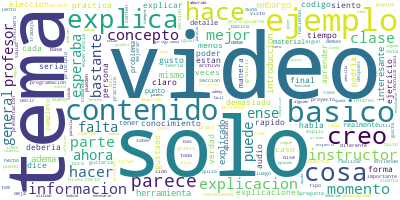

In [156]:
# Import the wordcloud library
from wordcloud import WordCloud
# Join the different processed titles together.
long_string = ','.join(list([' '.join(map(str, l)) for l in df_news['comment_cleaned']]))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()


Now we need to build the *corpus* and the *dictionary* that gensim need to work, to do that we need to pass a list of list of tokens

In [157]:
# las palabras "curso,clase" son stopwords

# MODELADO

Comparando:
Latent Dirichlet Allocation (LDA), 
Latent semantic analysis (LSA), 
Hierarchical Dirichlet Process (HDP)

Para evaluar los topics, usamos **topic coherence** (una medida de interpretación de topics).

https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0

In [158]:
%%capture
!pip install pyLDAvis==2.1.2



In [159]:
%%capture
import pyLDAvis.gensim
pyLDAvis.enable_notebook()


In [160]:
import pandas as pd
import numpy as np
import matplotlib.pyplot  as plt
from collections import Counter
import numpy as np
from nltk import word_tokenize, sent_tokenize
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords

import gensim
from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel
from gensim.models.ldamulticore import LdaMulticore
#from gensim.models.wrappers import LdaMallet
from gensim.corpora import Dictionary
from gensim import corpora

import pyLDAvis.gensim
pyLDAvis.enable_notebook()

import os, re, operator, warnings
warnings.filterwarnings('ignore')  
%matplotlib inline

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [161]:
# LDA MODEL

In [162]:
def display_topics(model, model_type="lda"):
    for topic_idx, topic in enumerate(model.print_topics()):
        print ("Topic %d:" % (topic_idx))
        if model_type== "hdp":
            print (" ".join(re.findall( r'\*(.[^\*-S]+).?', topic[1])), "\n")
        else:
            print (" ".join(re.findall( r'\"(.[^"]+).?', topic[1])), "\n")

Find out the optimal number of topics for the LDA model based on the coherence metric:

In [163]:
num_topics=10

###########
from gensim.test.utils import common_corpus, common_dictionary
from gensim.test.utils import datapath
from gensim.models.ldamodel import LdaModel
import shutil

# Load a potentially pretrained model from disk.
ldamodel = LdaModel.load("model/lda.model")

###########
# Print the fist 6 Keywords in the 10 topics
ldamodel.print_topics(num_topics, 5)


[(0,
  '0.018*"temas" + 0.017*"version" + 0.016*"informacion" + 0.015*"falta" + 0.014*"explicacion"'),
 (1,
  '0.018*"explicar" + 0.014*"paso" + 0.010*"explica" + 0.008*"hacer" + 0.008*"profesor"'),
 (2,
  '0.018*"creo" + 0.017*"basico" + 0.015*"ejemplos" + 0.014*"tema" + 0.013*"podria"'),
 (3,
  '0.021*"falta" + 0.017*"conceptos" + 0.012*"explica" + 0.012*"solo" + 0.010*"parte"'),
 (4,
  '0.036*"videos" + 0.025*"audio" + 0.015*"calidad" + 0.015*"video" + 0.014*"contenido"'),
 (5,
  '0.013*"profesor" + 0.013*"hace" + 0.012*"solo" + 0.010*"forma" + 0.008*"clases"'),
 (6,
  '0.016*"videos" + 0.015*"solo" + 0.014*"video" + 0.011*"puede" + 0.011*"ense"'),
 (7,
  '0.018*"solo" + 0.017*"basico" + 0.014*"ense" + 0.014*"eleccion" + 0.012*"parece"'),
 (8,
  '0.016*"contenido" + 0.014*"explicacion" + 0.013*"explica" + 0.013*"conceptos" + 0.013*"parece"'),
 (9,
  '0.046*"cosas" + 0.022*"explica" + 0.015*"explicar" + 0.013*"hace" + 0.011*"demasiado"')]

### Comparing the Model Coherence of the Best Models

we made 3 models, now let's compare each other's  coherence

In [164]:
ldatopics = [[word for word, prob in topic] for topicid, topic in ldamodel.show_topics(formatted=False)]

In [165]:
lda_coherence = CoherenceModel(topics=ldatopics, texts=df_news['comment_cleaned'].to_list(), dictionary=dictionary, window_size=10).get_coherence()
lda_coherence

0.31497405969644054

In [166]:
display_topics(ldamodel)

Topic 0:
temas version informacion falta explicacion deberia ejemplos esperaba interesante gustaria 

Topic 1:
explicar paso explica hacer profesor proyecto ejemplo tener mejor solo 

Topic 2:
creo basico ejemplos tema podria nivel mejor solo conceptos ejemplo 

Topic 3:
falta conceptos explica solo parte ejercicios programacion basicos ejemplos creo 

Topic 4:
videos audio calidad video contenido informacion mejorar mejor explicacion parece 

Topic 5:
profesor hace solo forma clases basico mejor codigo conceptos temas 

Topic 6:
videos solo video puede ense momento contenido presentacion informacion visto 

Topic 7:
solo basico ense eleccion parece hacer instructor mejor introduccion linux 

Topic 8:
contenido explicacion explica conceptos parece habla tema tem introduccion falta 

Topic 9:
cosas explica explicar hace demasiado basico rapido hacer explicaciones aprender 



It looks like the topics are:
* Topic 0: felicitaciones
* Topic 1: expectativas
* Topic 2: experiencia
* Topic 3: contenido
* Topic 4: instructor
* Topic 5: material
* Topic 6: video
* Topic 7: lenguaje
* Topic 8: ejercicios
* Topic 9: titulo
* Topic 10: temas
* Topic 11: explicación


Let´s check the keyword when we selecting another number of topics (14)

# Classifiying all documents

now that we have been select the best model and topics number, is time to assign a topic to each document, means **cluster** according to the topics

In [167]:
dictionary = Dictionary.load("dictionary.dict")
corpus = [dictionary.doc2bow(text) for text in df_news['comment_cleaned'].to_list()]
corpus[232]

[(99, 1),
 (265, 1),
 (340, 1),
 (437, 1),
 (815, 2),
 (969, 1),
 (1048, 1),
 (1062, 1),
 (1063, 1),
 (1064, 1)]

In [168]:
len(corpus)

18883

In [169]:
unseen_doc = corpus[232]
print(unseen_doc)
vector = ldamodel[unseen_doc]  # get topic probability distribution for a document
print(vector)

[(99, 1), (265, 1), (340, 1), (437, 1), (815, 2), (969, 1), (1048, 1), (1062, 1), (1063, 1), (1064, 1)]
[(6, 0.70269895), (7, 0.2305783)]


In [170]:
from tqdm.notebook import tqdm_notebook

def format_topics_sentences(ldamodel=0, corpus=corpus, texts=0, texts_cleaned=0):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, rowX in tqdm_notebook(enumerate(corpus), total=len(corpus)):
        row = ldamodel[rowX]
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    
    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    contents = pd.Series(texts_cleaned)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)

    sent_topics_df.columns = ['Dominant_Topic_number', 'Perc_Contribution', 'Topic_Keywords', 'Text', 'Text_Cleaned']
    return(sent_topics_df)


#df_topic_sents_keywords = format_topics_sentences(ldamodel, doc_lda=doc_lda, texts=df_news['comment_cleaned'].to_list())
df_topic_sents_keywords = format_topics_sentences(ldamodel, corpus=corpus, texts=df_news['comment'].to_list(), texts_cleaned=df_news['comment_cleaned'].to_list())



  0%|          | 0/18883 [00:00<?, ?it/s]

In [171]:
# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic_number', 'Topic_Perc_Contrib', 'Keywords', 'Text', 'Text_Cleaned']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic_number,Topic_Perc_Contrib,Keywords,Text,Text_Cleaned
0,0,7.00,0.59,"solo, basico, ense, eleccion, parece, hacer, instructor, mejor, introduccion, linux",como introducción esta bien pero deberían de hacerlo mas dirigido a RPA con fotos de RPAS,"[introduccion, deberian, hacerlo, dirigido, fotos, rp]"
1,1,8.00,0.55,"contenido, explicacion, explica, conceptos, parece, habla, tema, tem, introduccion, falta",Explican poco... se lee la mayoría,"[explican, mayori]"
2,2,4.00,0.59,"videos, audio, calidad, video, contenido, informacion, mejorar, mejor, explicacion, parece","es muy pronto para evaluarlo, comparandolo con la calidad de otros cursos este es bajo, no se pueden descargar los archivos ya que no estan en PDF y el sonido es malo, se escucha turbio.","[pronto, evaluarlo, comparandolo, calidad, bajo, pueden, descargar, archivos, estan, sonido, malo, escucha, turbi]"
3,3,2.00,0.46,"creo, basico, ejemplos, tema, podria, nivel, mejor, solo, conceptos, ejemplo","Excelente, muy detallado. Si fuera menos « leído » la calidad sería superior! El tema da para explicar más y leer menos","[detallado, menos, leido, calidad, seria, superior, tema, explicar, leer, men]"
4,4,8.00,0.58,"contenido, explicacion, explica, conceptos, parece, habla, tema, tem, introduccion, falta","Me parece que podria dar algun pequeño repaso de terminos comunes, ademas de dar mas ejemplos","[parece, podria, algun, peque, repaso, terminos, comunes, ademas, ejempl]"
5,5,5.00,0.60,"profesor, hace, solo, forma, clases, basico, mejor, codigo, conceptos, temas",Una parte del curso fue algo que el profesor mismo tiene en otro curso gratis.\nPero lo especializado a Hacking está igualmente bien explicado.,"[parte, profesor, mismo, gratis, especializado, hacking, igualmente, explic]"
6,6,6.00,0.60,"videos, solo, video, puede, ense, momento, contenido, presentacion, informacion, visto","No me gusto. Más que Hacking con Python... era aprende Python, de hacking poco y nada.","[gusto, hacking, python, aprende, python, hacking]"
7,7,6.00,0.57,"videos, solo, video, puede, ense, momento, contenido, presentacion, informacion, visto",habla de hacking y son dos apartados que solo son web. DECEPCIONANTE.,"[habla, hacking, apartados, solo, decepcion]"
8,8,0.00,0.40,"temas, version, informacion, falta, explicacion, deberia, ejemplos, esperaba, interesante, gustaria","Es una introducción breve y rápida al lenguaje de programación Python. No es un curso de Auditoria informática, ya que al final del curso se da un breve ejemplo de como hacer Scraping.No ha cumplido exactamente con mis expectativas pero he de reconocer que el tutor se ha esforzado e involucrado en los ejemplos del lenguaje.","[introduccion, breve, rapida, lenguaje, programacion, python, auditoria, informatica, final, breve, ejemplo, hacer, cumplido, exactamente, expectativas, reconocer, tutor, esforzado, involucrado, ejemplos, lenguaj]"
9,9,2.00,0.45,"creo, basico, ejemplos, tema, podria, nivel, mejor, solo, conceptos, ejemplo",Me pareció super bien el curso para las personas que quieran iniciarse en el lenguaje de programación python,"[parecio, super, personas, quieran, iniciarse, lenguaje, programacion, python]"


In [172]:
topic_nums=range(10)
for topic_num in topic_nums:
    print(topic_num)
    print(ldamodel.show_topic(topic_num))
    display(df_dominant_topic[df_dominant_topic["Dominant_Topic_number"]==topic_num].sort_values("Topic_Perc_Contrib",ascending=False)["Text"].head(4).tolist())
    print()

0
[('temas', 0.018332608), ('version', 0.016877582), ('informacion', 0.01576714), ('falta', 0.01454716), ('explicacion', 0.013653057), ('deberia', 0.011959253), ('ejemplos', 0.011419032), ('esperaba', 0.010760451), ('interesante', 0.009923366), ('gustaria', 0.009441767)]


['El curso es muy bueno, el profesor demuestra conocimiento pleno de los temas, sin embargo seria bueno que indique que archivo que se usará en cada clase principalmente al iniciar el curso y ser un poco mas ordenado.',
 'El curso cumple una función introductoria, lo cual no está mal, sin embargo considero que podría profundizar un poco más en algunos aspectos. Por otro lado, algunos de los datos para trabajar en arcmap tienen errores.',
 'Buen curso para iniciarse en el manejo de este framework sin embargo le falta el desarrollo de varios temas muy importantes co o la gestión de las sesiones de usuario entre otros.',
 'la informacion es bastante util,sin embargo, me gustaria se prefundisara un poco mas en ciertos aspectos. tener mas ejemplos de cada tema que se hable.']


1
[('explicar', 0.018331844), ('paso', 0.014123334), ('explica', 0.009632547), ('hacer', 0.008315461), ('profesor', 0.007847014), ('proyecto', 0.0074809357), ('ejemplo', 0.0072999876), ('tener', 0.007188237), ('mejor', 0.0070553795), ('solo', 0.006615273)]


['Explica bien pero no hay ejemplos de proyectos reales donde aplicar lo que enseña , lo cual se queda bastante cojo el curso.\nSi explica el justify-content que haga un mini proyecto de como se aplica ese concepto en una pagina web real.\nluego la propiedad flex: 1 0 dice que se omite la propiedad flex-shrink cuando no es así , el valor por defecto de flex-shrink es 1 lo cual el elemento hijo se queda igual por eso no hay modificación en el ancho de ese elemento.',
 'Muy buena explicación para iniciarse en el mundo de CSS, yo diría que la mejor forma de hacerlo, mas si se complementa con el curso de HTML del mismo Navis Code. Solo agregar que me hubiese gustado ver una sección para explicar brevemente que significa cada propiedad utilizada a lo largo del tutorial para que en la marcha se haga mas didáctico ver el avance con los proyectos 1 y 2. Lo demás excelente, nada que decir.',
 'Un desastre, aunque he sacado varias veces el 100% de las preguntas de pruebas, a la hora de la verdad


2
[('creo', 0.017740551), ('basico', 0.016996715), ('ejemplos', 0.015167167), ('tema', 0.0143293105), ('podria', 0.012605028), ('nivel', 0.010374517), ('mejor', 0.009211609), ('solo', 0.008764898), ('conceptos', 0.008283913), ('ejemplo', 0.0071921158)]


['Sí alguien va empezando por con la programación, al estar desactualizado el video con relación al Butterknife (que fue suplantado por ViewBinding) y al llegar al video del recurso en donde "explica" cómo tratar este cambio, es algo complicado. De igual forma, tiene otro video donde explica desde 0 cómo iniciar con Viewbinding, y creo que ese sería el video correcto al que debe redirigir',
 'Realmente no ayudó en nada, el título le queda demasiado grande; el nombre que yo le pondría sería: "Mi primera aplicación con Android (Primeros pasos)". Mostrar Android N como novedad es demasiado para este curso ya que no explican la importancia de las API\'s y la elección de estás.',
 'seria excelente una mejor explicacion, donde adquirir ciertos dispositivos, terminos o terminologia usada entre otros, uso de otros dispositivos y no exactamente el que el usa ya que no muchos tenemos acceso al dispositivo y no podemos poner en practica lo que se aprende.',
 'Cumplió con mis expectativas de apren


3
[('falta', 0.02112924), ('conceptos', 0.017165761), ('explica', 0.012150118), ('solo', 0.011533389), ('parte', 0.01031506), ('ejercicios', 0.009163799), ('programacion', 0.008761048), ('basicos', 0.0085406955), ('ejemplos', 0.008325609), ('creo', 0.007732302)]


['Siento que el curso está bastante desactualizado en lo que respecta a las herramientas que se utilizan para el hacking, ya que algunas están obsoletas o ya cambiaron sus términos de licencia y no se pueden explotar al 100%.\n\nAún así en lo que respecta a teoría si aclara bastante el panorama de cómo trabajan los hackers o cómo le hacen para llevar a cabo su "trabajo".',
 'Hasta que llego al punto de los test perfecto. Buena refactorización y trucos. La explicación de como implementar los test nula. No entiendo nada en el primer test del endpoint Get. Da por hecho que sabemos lo que hay que hacer con JEST pero no tengo ni idea de lo que está explicando. \n\nGracias de todas formas',
 'Entre la oferta de cursos gratis me llamó la atención este curso, en un principio pensé que sería un curso para mejorar mi carrera profesional pero se trata de un curso que te educa para desarrollar tu actividad laboral cuidando tu salud.\n\nLo recomiendo aunque se me ha hecho un poco pesado, creo que e


4
[('videos', 0.03557409), ('audio', 0.025063245), ('calidad', 0.015417595), ('video', 0.014812847), ('contenido', 0.013712426), ('informacion', 0.012223801), ('mejorar', 0.011098064), ('mejor', 0.010130064), ('explicacion', 0.0091609005), ('parece', 0.008742268)]


['Falta mas seriedad del instructor, dice mucho " eh, eh, eh, perdon, eh, eh, perdon." no es seguro de si mismo, demuestra duda y falta de conocimiento. y ademas la fuente  de información es de wikipedia, son fuente dudosa, que cualquiera puede editar y agregar cualquier cosa. debe ser fuente confiable. wikipedia no puede ser fuente de información para un curso que dice ser serio.',
 'Este curso estaría mejor si se hubiera sido subtitulado (como las peliculas) el instructor a pesar sus buenas intenciones, se pierde al dar explicaciones y creo que hace más largos los videos de lo que en realidad deberían de ser, se ve que no tenia un guión preparado, esto deriva en que el instructor tiene una "muletilla" deseperante que esta en la mayoría de las lecciones que vi, es un "ehh, ehh, ehh" como si pensara que decir.\nAdemás juro que escuche ladrar perros y personas hablaban en el fondo. En fin.',
 'Definitivamente esto es una recopilación de videos de YouTube, no estoy seguro si Udemy es la 


5
[('profesor', 0.012601818), ('hace', 0.012521222), ('solo', 0.012320195), ('forma', 0.009869721), ('clases', 0.008016671), ('basico', 0.007745398), ('mejor', 0.0066153915), ('codigo', 0.0064034085), ('conceptos', 0.006386699), ('temas', 0.0060220626)]


['Primero de todo el titulo es un poco engañoso. Que el curso se llame master en machine learning que es lo que me interesaba y realmente no se vea nada de machine learning ha sido un poco decepcionante. Al principio era en plan veremos como limpiar datos, veremos como aplicarlo a machine learning, etc y por ello me quede hasta el final (aunque por el temario de curso no me diese esa impresión, pero bueno dije al principio hará un repaso de los lenguajes y se irá acercando más como decía al principio).\nEl segundo punto es que encuentro que el curso no está conexo. Es decir que veo que al final se ha ordenado de otra forma. Da la impresión que por los comentarios, primero tuviese que ir todo lo de R y luego todo lo de Python. Además a veces oías algo del estilo "como vimos al final de la unidad anterior" cuando a lo mejor hace dos temas que lo vimos o por ejemplo en la unidad 65 (La estadística, la base para\ncualquier analista de datos) es como si fuese sacado de otro curso porque al 


6
[('videos', 0.015525432), ('solo', 0.014996568), ('video', 0.0136888735), ('puede', 0.0106143), ('ense', 0.010544723), ('momento', 0.009770916), ('contenido', 0.009030324), ('presentacion', 0.008603166), ('informacion', 0.008364057), ('visto', 0.007891148)]


['empezando por que no se llama como el curso en el que yo me matriculé, y eso no crea confianza. Yo me matriculé de Teledetección, y a pesar de que el temario pueda ser compartido o incluso igual, estoy haciendo un curso que no se llama así. Los últimos 10 ó 12 módulos que he visto son todos iguales, duran 2 minutos y tras repetir lo mismo al inicio y al final, te queda 1 minuto de video, cuya metodología se repite. Las combinaciones de bandas y la interpretación se puede exponer de una manera mucho más aprovechable para el alumno.',
 'Las explicaciones son muy claras, sin embargo, creo que el alcance de lo que se puede hacer con la información es muy limitado. Ejemplo: únicamente mercancías livianas, con proveedores que manejen DDP y sólo mediante transporte aéreo. Ya mejor díganme que sólo puedo importar funkos.',
 'al ingresar al primer modulo, se nos indica leer un artículo en una página web de un periódico de Colombia, pues el vínculo no existe y te lleva  a la misma página, ofre


7
[('solo', 0.018478401), ('basico', 0.016931616), ('ense', 0.01383008), ('eleccion', 0.013503557), ('parece', 0.011532184), ('hacer', 0.011314513), ('instructor', 0.009742705), ('mejor', 0.009032673), ('introduccion', 0.007768075), ('linux', 0.0076965434)]


["So far it's been a very enjoyable course, I like it.\n\nI understand that this introductory course consists of a summary which in turn consists of some videos of the other courses of the same author. \n\nHowever, it is a bit annoying that it alludes to videos that are not part of this one, particularly when it talks about the video about sharpening formones that is not included in this course. On the other hand, the final video of the finishes has nothing to do, the only justification I find for its inclusion in this course is because at the end promotes some more advanced work and courses.\n\nFor the rest, I reaffirm what I said at the beginning.",
 "I'd like to be honest with you my friend, I think you have the right idea but it isn't implemented in a good way, you don't need to repeat the words during the video, because it's monotonous, I think you could simulate situations of the real life and it'll be more interesting. Great project.",
 'Things to improve: \n-Some times (not man


8
[('contenido', 0.015695354), ('explicacion', 0.013638228), ('explica', 0.013353598), ('conceptos', 0.013214575), ('parece', 0.012901588), ('habla', 0.010801068), ('tema', 0.010662903), ('tem', 0.009797305), ('introduccion', 0.009106276), ('falta', 0.008676541)]


['En primer lugar, me parece un curso útil, que traza algunas líneas del marketing online.\nSin embargo, considero que las explicaciones se quedan faltas de contenido, que los ejemplos en muchos casos son pobres y que algunas de las expresiones utilizadas no son fáciles de comprender.\nA pesar de todo, gracias por su curso.\nUn saludo.',
 'Es muy desmotivante ver que el tutor hace varios meses no responde las inquietudes de sus alumnos, las explicaciones son demasiado cortas , y no explica bien como es el manejo de los futuros.\nEn lo referente al psicotrading deja mucho que desear.\n\nRealmente tenia una mejor expectativa del curso',
 'La explicacion muchas veces es poco clara debido a la forma de expresarse del docente. \nAdemas habla demasiado rapido por ser un curso "basico" y se mueve demasiado rapidamente con el cursor dando "por hecho" muchos aspectos que no los son para un principiante',
 'El contenido es claro e interesante, ya he tomado un par de cursos con Fabian y me han si


9
[('cosas', 0.046243057), ('explica', 0.021627026), ('explicar', 0.015366635), ('hace', 0.013491512), ('demasiado', 0.010975455), ('basico', 0.010664554), ('rapido', 0.009499844), ('hacer', 0.009072226), ('explicaciones', 0.008533129), ('aprender', 0.008357799)]


['El curso está bien para iniciarse en Unity y echarle una tarde viendo funcionalidades básicas... Pero está incompleto, no haces más que diseñar un nivel, una moneda y para casa. Si quieres hacer el juego final tienes que hacer otro curso de pago. Como digo, un poco inutil hacer este curso, pero si nunca has tocado Unity sacas una idea muy superficial de como funciona.',
 'Es un buen curso para empezar, aprendes varias cosas pero no es un curso completo sobre ASP.NET MVC. Aunque explica varios temas importantes la verdad es que se dedica mucho a crear proyectos y explicar que fue lo que creo el Framework. Lo recomiendo si eres una persona que se esta iniciando en el desarrollo web pero si no es el caso no creo que vallas a aprender nada nuevo.',
 'El curso se titula: mi primer juego con unity 5. Pensé que se iba a realizar el juego completo y no solo el diseño. De todas formas me gustó ver este curso gratuito pues es la primera vez que toco Unity y me ayudó mucho a la hora de interact

In [173]:
topic_vec = np.array([0] * num_topics) 
print(topic_vec)
topic_vec[0]=10
print(topic_vec)


[0 0 0 0 0 0 0 0 0 0]
[10  0  0  0  0  0  0  0  0  0]


In [174]:
from tqdm import tqdm_notebook

#corpus_i = corpus[1000]
corp_list = []
for ii,unseen_doc in tqdm_notebook(enumerate(corpus), 
                         total=len(corpus), 
                         desc="Processing records"):
  #top_topics = (lda_model.get_document_topics(corp_ii,
  #                                      minimum_probability=0.0)
  #)
  #topic_vec = [top_topics[i][1] if top_topics[i][1]>0.1 else 0 for i in range(num_topics)]
  doc_lda_ii = ldamodel[unseen_doc]
  topic_vec = [0] * num_topics
  for yy,zz in doc_lda_ii:
    #if zz>0.1:
      topic_vec[yy] = zz

  corp_list.append(topic_vec)

Processing records:   0%|          | 0/18883 [00:00<?, ?it/s]

## Análisis de topicos

In [175]:
dg_topics = pd.DataFrame(corp_list)
dg_topics.tail(10)

,0,1,2,3,4,5,6,7,8,9
18873,0.00,0.00,0.00,0.00,0.82,0.00,0.00,0.00,0.00,0.00
18874,0.00,0.00,0.00,0.82,0.00,0.00,0.00,0.00,0.00,0.00
18875,0.00,0.53,0.00,0.00,0.00,0.00,0.00,0.00,0.31,0.00
18876,0.00,0.00,0.28,0.00,0.23,0.33,0.00,0.15,0.00,0.00
18877,0.70,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
18878,0.00,0.77,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
18879,0.00,0.00,0.19,0.00,0.59,0.00,0.16,0.00,0.00,0.00
18880,0.00,0.00,0.41,0.00,0.00,0.00,0.39,0.00,0.00,0.00
18881,0.00,0.00,0.00,0.00,0.66,0.00,0.00,0.00,0.23,0.00
18882,0.00,0.00,0.00,0.87,0.00,0.00,0.00,0.00,0.00,0.00


In [176]:
df_all = pd.merge(df_news, dg_topics.add_prefix('topic_'), left_index=True, right_index=True,)
df_all.tail()

,index,id,course,rating,comment,user,tag,comment_cleaned,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
18878,174120,44039526,2241124,1.50,El video de corta cada 30 segundos,Marcelo Vergara,neg,"[video, corta, cada, segund]",0.00,0.77,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
18879,174124,42312208,2241124,3.50,"Aplica el sentido común.La experiencia que aporta . Puntos claves para saber emprender. Características del vendedor, honestidad, claridad, confianza, querer Vender.",Jose Manuel Torres Segade,neg,"[aplica, comu, experiencia, aporta, puntos, claves, saber, emprender, caracteristicas, vendedor, honestidad, claridad, confianza, querer, vend]",0.00,0.00,0.19,0.00,0.59,0.00,0.16,0.00,0.00,0.00
18880,174126,40788704,2241124,3.00,"Creí que podía ser mas completo, pero me equivoqué",Cristian Vera,neg,"[crei, podia, completo, equivoqu]",0.00,0.00,0.41,0.00,0.00,0.00,0.39,0.00,0.00,0.00
18881,174137,34694642,2241124,3.50,El contenido es breve y muy bueno para quienes se inician como asesores inmobiliarios. Los videos son de regular calidad.,Lourdes Gallardo,neg,"[contenido, breve, inician, asesores, inmobiliarios, videos, regular, cal]",0.00,0.00,0.00,0.00,0.66,0.00,0.00,0.00,0.23,0.00
18882,174140,93644240,3202322,3.00,"Solo se explica la conexión web, sería lo suyo explicar la app descargada.",Janira Cumbajin,neg,"[solo, explica, conexion, seria, explicar, descarg]",0.00,0.00,0.00,0.87,0.00,0.00,0.00,0.00,0.00,0.00


In [177]:
len(df_news),len(dg_topics), len(df_all)

(18883, 18883, 18883)

In [178]:
df_all.to_csv("udemy_reviews_with_topics.csv.zip", 
           index=False, 
           compression="zip")


In [179]:
dg_topics.sum(axis=1).sample(10)

14477   0.94
3070    0.55
4821    0.90
9651    0.95
10083   0.90
13809   0.82
16709   0.90
16259   0.87
16707   0.82
13867   0.55
dtype: float64

In [180]:
((dg_topics.astype(bool)==False).sum(axis=1)==num_topics).sum()

0

In [181]:
len(dg_topics)

18883

<BarContainer object of 10 artists>

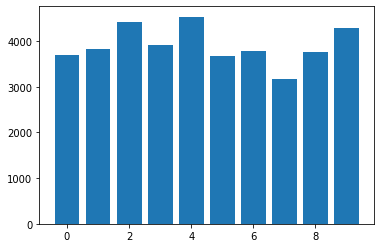

In [182]:
import matplotlib.pyplot as plt
plt.bar(dg_topics.columns, dg_topics.astype(bool).sum())

<BarContainer object of 10 artists>

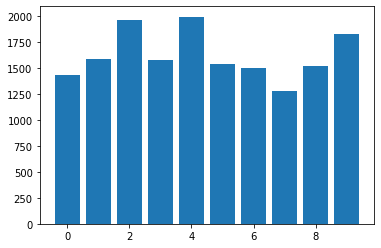

In [183]:
import matplotlib.pyplot as plt
plt.bar(dg_topics.columns, dg_topics.sum())

We selected the ldamodel with 12 topics and asigned a dominant topic to each document, now let map each topic with a label 

first let's create the dictionary

In [184]:
label_dicc = {0:'felicitaciones', 1:'expectativas', 2:'experiencia', 3: 'contenido', 4:'instructor', 5:'material', 6:'video', 
              7:'lenguaje', 8:'ejercicios', 9: 'titulo', 10:'temas', 11:'explicación'}

label_dicc = {0:"1_muy_introductorio",
1:"2_faltan_explicaciones",
2:"3_poco_preciso",
3:"4_falta_práctica",
4:"5_video_y_audio",
5:"6_dificil_de_seguir",
6:"7_nada",
7:"8_comentario_incomprensible",
8:"9_poco_claro",
9:"10_muy_superficial",
}

In [185]:
df_dominant_topic['Dominant_Topic_number'] = df_dominant_topic['Dominant_Topic_number'].astype('int64')

In [186]:
df_dominant_topic['Dominant_Topic'] = df_dominant_topic['Dominant_Topic_number'].map(label_dicc)

df_dominant_topic.to_csv("udemy_reviews_dominant.csv.zip", 
           index=False, 
           compression="zip")

df_dominant_topic.sample(10)

,Document_No,Dominant_Topic_number,Topic_Perc_Contrib,Keywords,Text,Text_Cleaned,Dominant_Topic
1778,1778,1,0.46,"explicar, paso, explica, hacer, profesor, proyecto, ejemplo, tener, mejor, solo","Si, basicamente jamas he visto esta materia y siento que me falta reforzarla con otro curso de Analisis de Estructural","[basicamente, jamas, visto, materia, siento, falta, reforzarla, analisis, estructural]",2_faltan_explicaciones
15640,15640,7,0.70,"solo, basico, ense, eleccion, parece, hacer, instructor, mejor, introduccion, linux",The course have a bunch of gramatical errors and typos in spanish,"[have, bunch, gramatical, errors, typos, spanish]",8_comentario_incomprensible
11299,11299,2,0.91,"creo, basico, ejemplos, tema, podria, nivel, mejor, solo, conceptos, ejemplo","Explica muy bien la causa de la insatisfacción sobre las relaciones, pero concreta poco sobre como remediar esa situación para, finalmente, intentar venderte sus sesiones de coaching.","[explica, causa, insatisfaccion, relaciones, concreta, remediar, situacion, finalmente, intentar, venderte, sesiones, coaching]",3_poco_preciso
23,23,6,0.91,"videos, solo, video, puede, ense, momento, contenido, presentacion, informacion, visto",Un poco rápido explicando el avance del código. En la pantalla se ve un poco pequeño y cuesta de leer el código.,"[rapido, explicando, avance, codigo, pantalla, peque, cuesta, leer, codig]",7_nada
16304,16304,8,0.52,"contenido, explicacion, explica, conceptos, parece, habla, tema, tem, introduccion, falta","Una Introducción interesante, sobre todo en las recomendaciones.","[introduccion, interesante, recomend]",9_poco_claro
14114,14114,5,0.57,"profesor, hace, solo, forma, clases, basico, mejor, codigo, conceptos, temas","Bueno, pero mi critica constructiva en mi punto de vista, es que, esperaba detalles especificos sin verborrea. Pero es bueno para empezar a tener interes en este tipo de lenguaje y comunicacion.","[bueno, critica, constructiva, punto, vista, esperaba, detalles, especificos, verborrea, empezar, tener, interes, tipo, lenguaje, comunicacion]",6_dificil_de_seguir
4069,4069,8,0.49,"contenido, explicacion, explica, conceptos, parece, habla, tema, tem, introduccion, falta",El curso me parece un poco lento y he notado que no responde a varias de las preguntas de otros estudiantes.,"[parece, lento, notado, responde, varias, preguntas, estudi]",9_poco_claro
18509,18509,4,0.52,"videos, audio, calidad, video, contenido, informacion, mejorar, mejor, explicacion, parece",Es acorde con lo que brinda la información es buena.,"[acorde, brinda, informacion]",5_video_y_audio
10780,10780,2,0.73,"creo, basico, ejemplos, tema, podria, nivel, mejor, solo, conceptos, ejemplo","Recien comienza. Pura teoria, espero el resto sea mas practico.","[recien, comienza, pura, teoria, espero, resto, pract]",3_poco_preciso
9108,9108,3,0.50,"falta, conceptos, explica, solo, parte, ejercicios, programacion, basicos, ejemplos, creo",CREO QUE PARA PRINCIPIANTES SI FALTA SER MAS PRECISO. SOBRE TODO EN LA LECTURA DE PARATITURAS NO LE ENTIENDO,"[creo, principiantes, falta, preciso, lectura, paratituras, ent]",4_falta_práctica


In [187]:
df_dominant_topic.isna().sum()

Document_No              0
Dominant_Topic_number    0
Topic_Perc_Contrib       0
Keywords                 0
Text                     0
Text_Cleaned             0
Dominant_Topic           0
dtype: int64

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fe201d21510>],
      dtype=object)

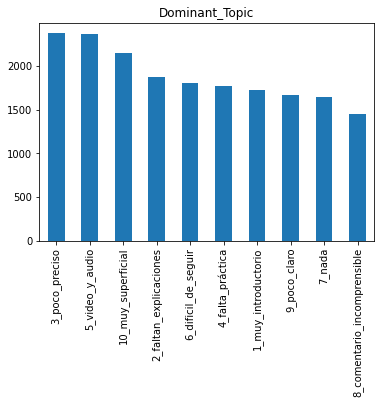

In [188]:
df_dominant_topic['Dominant_Topic'].value_counts().plot(kind='bar', subplots=True)

In [189]:
df_dominant_filtered.sample(10)

,Dominant_Topic,Text,Text_Cleaned
12766,9_poco_claro,"Aun no tengo una opinión ya que estoy en la introducción, no se ha metido al tema del curso.","[opinion, introduccion, metido, tem]"
1853,9_poco_claro,Para una introducción básica de conceptos sirve bastante.,"[introduccion, basica, conceptos, sirve, bast]"
18089,9_poco_claro,"NO, NO EXPLICAN TAN BIEN, NO RESUELVEN DUDAS Y SE TRABO","[explican, resuelven, dudas, trab]"
4192,9_poco_claro,"No explica con detalle solo de forma generalizada, quedan muchas dudas entre medio","[explica, detalle, solo, forma, generalizada, quedan, dudas, medi]"
7118,9_poco_claro,"Me parece un buen contenido, rápido pero posiblemente para personas que tengan ya una experiencia en el programa.","[parece, contenido, rapido, posiblemente, personas, experiencia, program]"
16694,9_poco_claro,"El curso casi no tiene nada que ver con servidores, esta a nivel estación de trabajo y muy básico, falta mas fluidez al explicar y realmente esperaba mucho mas","[casi, servidores, nivel, estacion, trabajo, basico, falta, fluidez, explicar, realmente, esper]"
18245,9_poco_claro,"Falto profundizar mas el tema del compost, se vio demasiado light. Lo mismo de otros paises que ya tienen menos producción de basura, solo se nombra, pero no se profundiza como ejemplo.","[falto, profundizar, tema, compost, demasiado, light, mismo, paises, menos, produccion, basura, solo, nombra, profundiza, ejempl]"
9139,9_poco_claro,"Es muy buen profesor, me ha estado gustando mucho el curso, sin embargo pienso que en HTML pudo desarrollar más.","[profesor, gustando, embargo, pienso, html, pudo, desarroll]"
14697,9_poco_claro,"Considero que el curso es bueno, practico, funcional y aborda temas específicos con explicaciones claras y sencillas.\n\nSaludos.","[considero, practico, funcional, aborda, temas, especificos, explicaciones, claras, sencillas, salud]"
2457,9_poco_claro,Las explicaciones iban bastante rápido y me costaba seguirle el ritmo.,"[explicaciones, iban, bastante, rapido, costaba, seguirle, ritm]"


,Dominant_Topic,Text,Text_Cleaned
11786,10_muy_superficial,"El curso está bien para iniciarse en Unity y echarle una tarde viendo funcionalidades básicas... Pero está incompleto, no haces más que diseñar un nivel, una moneda y para casa. Si quieres hacer el juego final tienes que hacer otro curso de pago. Como digo, un poco inutil hacer este curso, pero si nunca has tocado Unity sacas una idea muy superficial de como funciona.","[iniciarse, unity, echarle, tarde, viendo, funcionalidades, basicas, incompleto, haces, dise, nivel, moneda, casa, quieres, hacer, juego, final, hacer, pago, digo, inutil, hacer, nunca, tocado, unity, sacas, idea, superficial, funcion]"
3294,10_muy_superficial,"Es un buen curso para empezar, aprendes varias cosas pero no es un curso completo sobre ASP.NET MVC. Aunque explica varios temas importantes la verdad es que se dedica mucho a crear proyectos y explicar que fue lo que creo el Framework. Lo recomiendo si eres una persona que se esta iniciando en el desarrollo web pero si no es el caso no creo que vallas a aprender nada nuevo.","[empezar, aprendes, varias, cosas, completo, explica, varios, temas, importantes, verdad, dedica, crear, proyectos, explicar, creo, framework, recomiendo, persona, iniciando, desarrollo, caso, creo, vallas, aprender, nuev]"
11806,10_muy_superficial,El curso se titula: mi primer juego con unity 5. Pensé que se iba a realizar el juego completo y no solo el diseño. De todas formas me gustó ver este curso gratuito pues es la primera vez que toco Unity y me ayudó mucho a la hora de interactuar con la herramienta.,"[titula, primer, juego, unity, pense, realizar, juego, completo, solo, dise, todas, formas, gusto, gratuito, pues, primera, toco, unity, ayudo, hora, interactuar, herramient]"


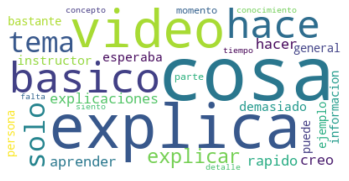

,Dominant_Topic,Text,Text_Cleaned
601,1_muy_introductorio,"El curso es muy bueno, el profesor demuestra conocimiento pleno de los temas, sin embargo seria bueno que indique que archivo que se usará en cada clase principalmente al iniciar el curso y ser un poco mas ordenado.","[profesor, demuestra, conocimiento, pleno, temas, embargo, seria, indique, archivo, usara, cada, clase, principalmente, iniciar, orden]"
1551,1_muy_introductorio,"El curso cumple una función introductoria, lo cual no está mal, sin embargo considero que podría profundizar un poco más en algunos aspectos. Por otro lado, algunos de los datos para trabajar en arcmap tienen errores.","[cumple, funcion, introductoria, embargo, considero, podria, profundizar, aspectos, lado, datos, trabajar, arcmap, error]"
12205,1_muy_introductorio,Buen curso para iniciarse en el manejo de este framework sin embargo le falta el desarrollo de varios temas muy importantes co o la gestión de las sesiones de usuario entre otros.,"[iniciarse, manejo, framework, embargo, falta, desarrollo, varios, temas, importantes, gestion, sesiones, usuari]"


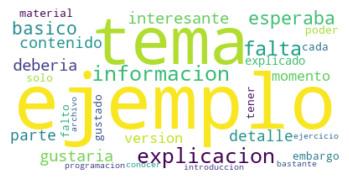

,Dominant_Topic,Text,Text_Cleaned
11707,2_faltan_explicaciones,"Explica bien pero no hay ejemplos de proyectos reales donde aplicar lo que enseña , lo cual se queda bastante cojo el curso.\nSi explica el justify-content que haga un mini proyecto de como se aplica ese concepto en una pagina web real.\nluego la propiedad flex: 1 0 dice que se omite la propiedad flex-shrink cuando no es así , el valor por defecto de flex-shrink es 1 lo cual el elemento hijo se queda igual por eso no hay modificación en el ancho de ese elemento.","[explica, ejemplos, proyectos, reales, aplicar, ense, queda, bastante, cojo, explica, justify, content, haga, mini, proyecto, aplica, concepto, pagina, real, luego, propiedad, flex, dice, omite, propiedad, flex, shrink, valor, defecto, flex, shrink, elemento, hijo, queda, igual, modificacion, ancho, element]"
17397,2_faltan_explicaciones,"Muy buena explicación para iniciarse en el mundo de CSS, yo diría que la mejor forma de hacerlo, mas si se complementa con el curso de HTML del mismo Navis Code. Solo agregar que me hubiese gustado ver una sección para explicar brevemente que significa cada propiedad utilizada a lo largo del tutorial para que en la marcha se haga mas didáctico ver el avance con los proyectos 1 y 2. Lo demás excelente, nada que decir.","[explicacion, iniciarse, mundo, diria, mejor, forma, hacerlo, complementa, html, mismo, navis, code, solo, agregar, gustado, seccion, explicar, brevemente, significa, cada, propiedad, utilizada, largo, tutorial, marcha, haga, didactico, avance, proyectos, demas, dec]"
483,2_faltan_explicaciones,"Un desastre, aunque he sacado varias veces el 100% de las preguntas de pruebas, a la hora de la verdad ni se parecen a las del examen real. Como no se actualice este curso es poco útil para el examen actual. Cierto es que las preguntas de ejemplo que vienen con el programa oficial tampoco se parecen al examen actual. Hay algo que no se ha actualizado debidamente","[desastre, sacado, varias, veces, preguntas, pruebas, hora, verdad, parecen, examen, real, actualice, util, examen, actual, cierto, preguntas, ejemplo, vienen, programa, oficial, tampoco, parecen, examen, actual, actualizado, debid]"


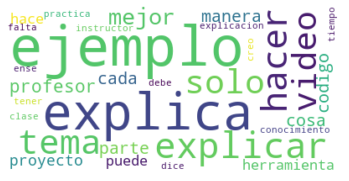

,Dominant_Topic,Text,Text_Cleaned
17152,3_poco_preciso,"Sí alguien va empezando por con la programación, al estar desactualizado el video con relación al Butterknife (que fue suplantado por ViewBinding) y al llegar al video del recurso en donde ""explica"" cómo tratar este cambio, es algo complicado. De igual forma, tiene otro video donde explica desde 0 cómo iniciar con Viewbinding, y creo que ese sería el video correcto al que debe redirigir","[alguien, empezando, programacion, desactualizado, video, relacion, butterknife, suplantado, viewbinding, llegar, video, explica, tratar, cambio, complicado, igual, forma, video, explica, iniciar, viewbinding, creo, seria, video, correcto, debe, redirig]"
18335,3_poco_preciso,"Realmente no ayudó en nada, el título le queda demasiado grande; el nombre que yo le pondría sería: ""Mi primera aplicación con Android (Primeros pasos)"". Mostrar Android N como novedad es demasiado para este curso ya que no explican la importancia de las API's y la elección de estás.","[realmente, ayudo, titulo, queda, demasiado, grande, nombre, pondria, seria, primera, aplicacion, android, primeros, pasos, mostrar, android, novedad, demasiado, explican, importancia, eleccion]"
2522,3_poco_preciso,"seria excelente una mejor explicacion, donde adquirir ciertos dispositivos, terminos o terminologia usada entre otros, uso de otros dispositivos y no exactamente el que el usa ya que no muchos tenemos acceso al dispositivo y no podemos poner en practica lo que se aprende.","[seria, mejor, explicacion, adquirir, ciertos, dispositivos, terminos, terminologia, usada, dispositivos, exactamente, acceso, dispositivo, podemos, poner, practica, aprend]"


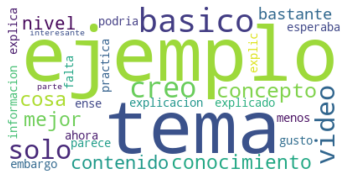

,Dominant_Topic,Text,Text_Cleaned
804,4_falta_práctica,"Siento que el curso está bastante desactualizado en lo que respecta a las herramientas que se utilizan para el hacking, ya que algunas están obsoletas o ya cambiaron sus términos de licencia y no se pueden explotar al 100%.\n\nAún así en lo que respecta a teoría si aclara bastante el panorama de cómo trabajan los hackers o cómo le hacen para llevar a cabo su ""trabajo"".","[siento, bastante, desactualizado, respecta, herramientas, utilizan, hacking, estan, obsoletas, cambiaron, terminos, licencia, pueden, explotar, respecta, teoria, aclara, bastante, panorama, trabajan, hackers, hacen, llevar, cabo, trabaj]"
3166,4_falta_práctica,Hasta que llego al punto de los test perfecto. Buena refactorización y trucos. La explicación de como implementar los test nula. No entiendo nada en el primer test del endpoint Get. Da por hecho que sabemos lo que hay que hacer con JEST pero no tengo ni idea de lo que está explicando. \n\nGracias de todas formas,"[llego, punto, test, perfecto, buena, refactorizacion, trucos, explicacion, implementar, test, nula, entiendo, primer, test, endpoint, hecho, sabemos, hacer, jest, idea, explicando, todas, form]"
13063,4_falta_práctica,"Entre la oferta de cursos gratis me llamó la atención este curso, en un principio pensé que sería un curso para mejorar mi carrera profesional pero se trata de un curso que te educa para desarrollar tu actividad laboral cuidando tu salud.\n\nLo recomiendo aunque se me ha hecho un poco pesado, creo que es un cursillo muy útil si nos valoramos lo más minimo.\n\nPablo","[oferta, gratis, llamo, atencion, principio, pense, seria, mejorar, carrera, profesional, trata, educa, desarrollar, actividad, laboral, cuidando, salud, recomiendo, hecho, pesado, creo, cursillo, util, valoramos, minimo, pabl]"


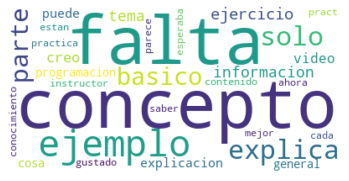

,Dominant_Topic,Text,Text_Cleaned
7271,5_video_y_audio,"Falta mas seriedad del instructor, dice mucho "" eh, eh, eh, perdon, eh, eh, perdon."" no es seguro de si mismo, demuestra duda y falta de conocimiento. y ademas la fuente de información es de wikipedia, son fuente dudosa, que cualquiera puede editar y agregar cualquier cosa. debe ser fuente confiable. wikipedia no puede ser fuente de información para un curso que dice ser serio.","[falta, seriedad, instructor, dice, perdon, perdon, seguro, mismo, demuestra, duda, falta, conocimiento, ademas, fuente, informacion, wikipedia, fuente, dudosa, cualquiera, puede, editar, agregar, cualquier, cosa, debe, fuente, confiable, wikipedia, puede, fuente, informacion, dice, seri]"
4503,5_video_y_audio,"Este curso estaría mejor si se hubiera sido subtitulado (como las peliculas) el instructor a pesar sus buenas intenciones, se pierde al dar explicaciones y creo que hace más largos los videos de lo que en realidad deberían de ser, se ve que no tenia un guión preparado, esto deriva en que el instructor tiene una ""muletilla"" deseperante que esta en la mayoría de las lecciones que vi, es un ""ehh, ehh, ehh"" como si pensara que decir.\nAdemás juro que escuche ladrar perros y personas hablaban en el fondo. En fin.","[estaria, mejor, sido, subtitulado, peliculas, instructor, pesar, intenciones, pierde, explicaciones, creo, hace, largos, videos, realidad, deberian, tenia, guion, preparado, deriva, instructor, muletilla, deseperante, mayoria, lecciones, pensara, decir, ademas, juro, escuche, ladrar, perros, personas, hablaban, fond]"
18866,5_video_y_audio,"Definitivamente esto es una recopilación de videos de YouTube, no estoy seguro si Udemy es la plataforma ideal, aquí se viene a tomar cursos y a aprender no a ver publicidad de Solange Candelo y su empresa Realtaria, tiene poca información útil como curso pero las partes en las que los agentes inmobiliarios hablan de por qué Realtaria es una buena empresa no me interesa en lo absoluto, deberian quitarlo, en fin, no me puedo quejar ya que la poca información pues es gratis.","[definitivamente, recopilacion, videos, youtube, seguro, udemy, plataforma, ideal, aqui, viene, tomar, aprender, publicidad, solange, candelo, empresa, realtaria, poca, informacion, util, partes, agentes, inmobiliarios, hablan, realtaria, empresa, interesa, absoluto, deberian, quitarlo, puedo, quejar, poca, informacion, pues, gratis]"


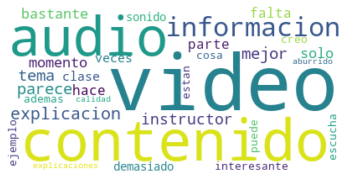

,Dominant_Topic,Text,Text_Cleaned
12421,6_dificil_de_seguir,"Primero de todo el titulo es un poco engañoso. Que el curso se llame master en machine learning que es lo que me interesaba y realmente no se vea nada de machine learning ha sido un poco decepcionante. Al principio era en plan veremos como limpiar datos, veremos como aplicarlo a machine learning, etc y por ello me quede hasta el final (aunque por el temario de curso no me diese esa impresión, pero bueno dije al principio hará un repaso de los lenguajes y se irá acercando más como decía al principio).\nEl segundo punto es que encuentro que el curso no está conexo. Es decir que veo que al final se ha ordenado de otra forma. Da la impresión que por los comentarios, primero tuviese que ir todo lo de R y luego todo lo de Python. Además a veces oías algo del estilo ""como vimos al final de la unidad anterior"" cuando a lo mejor hace dos temas que lo vimos o por ejemplo en la unidad 65 (La estadística, la base para\ncualquier analista de datos) es como si fuese sacado de otro curso porque al iniciar el video en el video se aprecian cosas tipo summary(data$mpg) o str(data$cylinders) que no lo hemos visto y empieza diciendo ""como acabamos de ver"". Dices bueno esto no tendrá importancia, lo que requiere es lo que vendrá a continuación. Pero ves que no, que como datos usa data$mpg que no sabemos ni como se obtiene, si mediante paquete o ese data y ese mpg viene de alguna instrucción o de donde. \nEl tercer punto y algo más positivo, es que a pesar de esto, me pareció que supo explicar muy bien tanto en el video como en el material proporcionado y poner unos ejemplos sencillos y claros. Es por esta parte que añadí la media estrella más, pero si no iba de cabeza a la estrella por todo lo comentado al principio que sinceramente me ha decepcionado mucho","[primero, titulo, enga, llame, master, machine, learning, interesaba, realmente, machine, learning, sido, decepcionante, principio, plan, veremos, limpiar, datos, veremos, aplicarlo, machine, learning, ello, quede, final, temario, diese, impresion, dije, principio, hara, repaso, lenguajes, acercando, decia, principio, segundo, punto, encuentro, conexo, decir, final, ordenado, forma, impresion, comentarios, primero, luego, python, ademas, veces, oias, estilo, vimos, final, unidad, anterior, mejor, hace, temas, vimos, ejemplo, unidad, estadistica, base, paracualquier, analista, datos, sacado, iniciar, video, video, aprecian, cosas, tipo, summary, data, data, cylinders, visto, empieza, diciendo, acabamos, dices, tendra, importancia, requiere, vendra, continuacion, datos, data, sabemos, obtiene, mediante, paquete, data, viene, alguna, instruccion, tercer, ...]"
509,6_dificil_de_seguir,"Comparada con los cursos de Logali, este da la impresión de estar menos preparado, trata de explicar los temas pero tiene que ir resolviendo incidentes conforme se desarrolla el curso. Es bueno, pero muy corto; para la amplia gama de cosas nuevas del abap 7.4 esta muy limitado. Además, insisto, si se tiene la referencia de los cursos de Logali, a este le falta mas forma y estructura. Revisen el curso de POO ABAP de Logali, diapositivas animadas, curso preparado de inicio a fin, ejemplos claro, precisos y sin error. La verdad, estoy muy decepcionado de lo que pague.","[comparada, logali, impresion, menos, preparado, trata, explicar, temas, resolviendo, incidentes, conforme, desarrolla, corto, amplia, gama, cosas, nuevas, abap, limitado, ademas, insisto, referencia, logali, falta, forma, estructura, revisen, abap, logali, diapositivas, animadas, preparado, inicio, ejemplos, claro, precisos, error, verdad, decepcionado, pag]"
2809,6_dificil_de_seguir,"Quiero agradecer por tan valiosa información, en mi caso el Estudio del idioma Ingles no se meda de forma natural y fácil, pero ahora que escucho la profesora ANNA me trasmitió tanta pasión y positivismo que estoy deseosa de iniciar y poder llegar al final con muy buenos resultados.\nGracias profesora Anna 

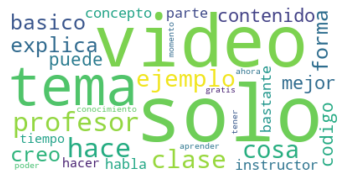

,Dominant_Topic,Text,Text_Cleaned
1554,7_nada,"empezando por que no se llama como el curso en el que yo me matriculé, y eso no crea confianza. Yo me matriculé de Teledetección, y a pesar de que el temario pueda ser compartido o incluso igual, estoy haciendo un curso que no se llama así. Los últimos 10 ó 12 módulos que he visto son todos iguales, duran 2 minutos y tras repetir lo mismo al inicio y al final, te queda 1 minuto de video, cuya metodología se repite. Las combinaciones de bandas y la interpretación se puede exponer de una manera mucho más aprovechable para el alumno.","[empezando, llama, matricule, crea, confianza, matricule, teledeteccion, pesar, temario, pueda, compartido, incluso, igual, haciendo, llama, ultimos, modulos, visto, iguales, duran, minutos, tras, repetir, mismo, inicio, final, queda, minuto, video, cuya, metodologia, repite, combinaciones, bandas, interpretacion, puede, exponer, manera, aprovechable, alumn]"
4128,7_nada,"Las explicaciones son muy claras, sin embargo, creo que el alcance de lo que se puede hacer con la información es muy limitado. Ejemplo: únicamente mercancías livianas, con proveedores que manejen DDP y sólo mediante transporte aéreo. Ya mejor díganme que sólo puedo importar funkos.","[explicaciones, claras, embargo, creo, alcance, puede, hacer, informacion, limitado, ejemplo, unicamente, mercancias, livianas, proveedores, manejen, solo, mediante, transporte, aereo, mejor, diganme, solo, puedo, importar, funk]"
12566,7_nada,"al ingresar al primer modulo, se nos indica leer un artículo en una página web de un periódico de Colombia, pues el vínculo no existe y te lleva a la misma página, ofreciendo otro tipo de información del día y no sobre el artículo donde informa la creación de la emisora de radio","[ingresar, primer, modulo, indica, leer, articulo, pagina, periodico, colombia, pues, vinculo, existe, lleva, misma, pagina, ofreciendo, tipo, informacion, articulo, informa, creacion, emisora, radi]"


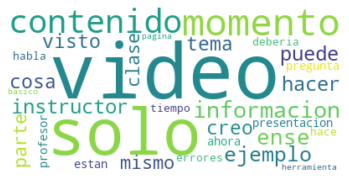

,Dominant_Topic,Text,Text_Cleaned
13429,8_comentario_incomprensible,"So far it's been a very enjoyable course, I like it.\n\nI understand that this introductory course consists of a summary which in turn consists of some videos of the other courses of the same author. \n\nHowever, it is a bit annoying that it alludes to videos that are not part of this one, particularly when it talks about the video about sharpening formones that is not included in this course. On the other hand, the final video of the finishes has nothing to do, the only justification I find for its inclusion in this course is because at the end promotes some more advanced work and courses.\n\nFor the rest, I reaffirm what I said at the beginning.","[been, very, enjoyable, like, understand, that, this, introductory, consists, summary, which, turn, consists, some, videos, other, same, author, however, annoying, that, alludes, videos, that, part, this, particularly, when, talks, about, video, about, sharpening, formones, that, included, this, other, hand, final, video, finishes, nothing, only, justification, find, inclusion, this, because, promotes, some, more, advanced, work, rest, reaffirm, what, said, beginning]"
9202,8_comentario_incomprensible,"I'd like to be honest with you my friend, I think you have the right idea but it isn't implemented in a good way, you don't need to repeat the words during the video, because it's monotonous, I think you could simulate situations of the real life and it'll be more interesting. Great project.","[like, honest, with, friend, think, have, right, idea, implemented, need, repeat, words, during, video, because, monotonous, think, could, simulate, situations, real, life, more, interesting, great, project]"
990,8_comentario_incomprensible,"Things to improve: \n-Some times (not many) the pronunciation of the words in Spanish is not correct and this could cause some confusion.\n-The practices appear before the explanation.\n-All assignments are the same, so it makes them a little boring. Try to vary the assignments.\n\nGood things:\n- The explanations are good\n- The material is good\n- Cases of study are great examples of how all this works and it also helps to understand that even though, Scrum@Scale defines some concepts and names to some roles, ceremonies and/or teams, it is also very flexible and can work with some little differences.\n-","[things, improve, some, times, many, pronunciation, words, spanish, correct, this, could, cause, some, confusion, practices, appear, before, explanation, assignments, same, makes, them, little, boring, vary, assignments, things, explanations, material, cases, study, great, examples, this, works, also, helps, understand, that, even, though, scrum, scale, defines, some, concepts, names, some, roles, ceremonies, teams, also, very, flexible, work, with, some, little, differenc]"


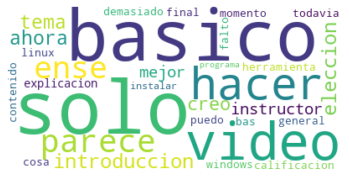

,Dominant_Topic,Text,Text_Cleaned
11029,9_poco_claro,"En primer lugar, me parece un curso útil, que traza algunas líneas del marketing online.\nSin embargo, considero que las explicaciones se quedan faltas de contenido, que los ejemplos en muchos casos son pobres y que algunas de las expresiones utilizadas no son fáciles de comprender.\nA pesar de todo, gracias por su curso.\nUn saludo.","[primer, lugar, parece, util, traza, lineas, marketing, online, embargo, considero, explicaciones, quedan, faltas, contenido, ejemplos, casos, pobres, expresiones, utilizadas, faciles, comprender, pesar, salud]"
2760,9_poco_claro,"Es muy desmotivante ver que el tutor hace varios meses no responde las inquietudes de sus alumnos, las explicaciones son demasiado cortas , y no explica bien como es el manejo de los futuros.\nEn lo referente al psicotrading deja mucho que desear.\n\nRealmente tenia una mejor expectativa del curso","[desmotivante, tutor, hace, varios, meses, responde, inquietudes, alumnos, explicaciones, demasiado, cortas, explica, manejo, futuros, referente, psicotrading, deja, desear, realmente, tenia, mejor, expect]"
12642,9_poco_claro,"La explicacion muchas veces es poco clara debido a la forma de expresarse del docente. \nAdemas habla demasiado rapido por ser un curso ""basico"" y se mueve demasiado rapidamente con el cursor dando ""por hecho"" muchos aspectos que no los son para un principiante","[explicacion, veces, clara, debido, forma, expresarse, docente, ademas, habla, demasiado, rapido, basico, mueve, demasiado, rapidamente, dando, hecho, aspectos, principi]"


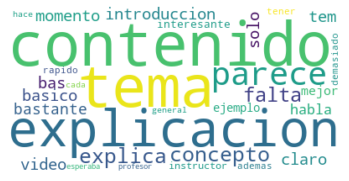

In [190]:
% matplotlib inline

topics = df_dominant_topic['Dominant_Topic'].unique()
topics.sort()

for topic in topics:
  print()
  print()
  df_dominant_filtered = df_dominant_topic[df_dominant_topic['Dominant_Topic']==topic].sort_values("Topic_Perc_Contrib",ascending=False)[["Dominant_Topic","Text","Text_Cleaned"]]
  display(df_dominant_filtered.head(3))
  # Import the wordcloud library
  from wordcloud import WordCloud
  # Join the different processed titles together.
  long_string = ','.join(list([' '.join(map(str, l)) for l in df_dominant_filtered['Text_Cleaned']]))
  # Create a WordCloud object
  wordcloud = WordCloud(background_color="white", max_words=30, contour_width=3, contour_color='steelblue')
  # Generate a word cloud
  wordcloud.generate(long_string)
  # Visualize the word cloud
  wordcloud.to_image()
  # Display the generated image:
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis("off")
  plt.show()


In [191]:
df_news['label'] = df_dominant_topic['Dominant_Topic']
df_news['label_id'] = df_dominant_topic['Dominant_Topic_number']
df_news['label_confidence'] = df_dominant_topic['Topic_Perc_Contrib']
df_news["label"].fillna("X",inplace=True)

Let's examine some text and its topics

In [192]:
df_news[['comment', 'label','label_id']].sample(10)

,comment,label,label_id
14367,por que va iniciando ya con mas contenido podria dar una mejor opinion,3_poco_preciso,2
17220,Demasiado basico; se aprende mas con un tutorial de Youtube.,10_muy_superficial,9
7022,"El curso es bueno y completo, pero muchas de las clases no están grabadas en vídeo Full HD, y si tienes un monitor con una resolución mayor (en mi caso, 4K), se notan mucho los pixels. El resultado son vídeos algo borrosos, cosa que no influye en el aprendizaje, pero que se convierte en algo bastante molesto.",5_video_y_audio,4
5436,"Pesimo curso. Cero didactica, no explica los propositos ni la filosofia detras de cada funcionalidad. No actualizan los videos a la nueva interfaz de aws, por lo q muchas opciones q mencionan cuesta encontrarlas. Tampoco explican el proposito o en que casos sirven las distintas opciones que ofrece cada caracteristica de aws.\nPara rematarla, el tono del profesor es harto monotono, aburrido, no transmite nada de entusiasmo, y las presentaciones son meros textos propios de un estudiante secundario, sin un solo diagrama que ayude a comprender mejor los conceptos",2_faltan_explicaciones,1
4459,"No está actualizado, en algunos temas no pude avanzar porque los archivos están actualizados y cambiados a comparación del curso",1_muy_introductorio,0
13358,Considero que faltó preparar más las lecciones por parte del instructor.,4_falta_práctica,3
5736,La calidad del sonido no es la mejor,5_video_y_audio,4
6690,"Si, para un abrebocas. No me gustó mucho la parte de ventas de Lanza tu Funnel ni me quedó claro si Exur es una herramienta parecida a Word Press o qué. Fue mucho ventas de las herramientas más que enseñarnos mejor a cómo hacer los funnels.",4_falta_práctica,3
10103,En general me gustó mucho el curso como una introducción básica al HTML pero me hubiera gustado profundizar más en el apartado de User Experience. Muchas gracias,1_muy_introductorio,0
8270,todo esta muy bien por ahora,2_faltan_explicaciones,1


In [193]:
for label_id in range(10):
    display(df_news[ df_news['label_id'] == label_id].sort_values(by='label_confidence',ascending=False)[['label_id','label','comment','comment_cleaned']].head(5))

,label_id,label,comment,comment_cleaned
601,0,1_muy_introductorio,"El curso es muy bueno, el profesor demuestra conocimiento pleno de los temas, sin embargo seria bueno que indique que archivo que se usará en cada clase principalmente al iniciar el curso y ser un poco mas ordenado.","[profesor, demuestra, conocimiento, pleno, temas, embargo, seria, indique, archivo, usara, cada, clase, principalmente, iniciar, orden]"
1551,0,1_muy_introductorio,"El curso cumple una función introductoria, lo cual no está mal, sin embargo considero que podría profundizar un poco más en algunos aspectos. Por otro lado, algunos de los datos para trabajar en arcmap tienen errores.","[cumple, funcion, introductoria, embargo, considero, podria, profundizar, aspectos, lado, datos, trabajar, arcmap, error]"
12205,0,1_muy_introductorio,Buen curso para iniciarse en el manejo de este framework sin embargo le falta el desarrollo de varios temas muy importantes co o la gestión de las sesiones de usuario entre otros.,"[iniciarse, manejo, framework, embargo, falta, desarrollo, varios, temas, importantes, gestion, sesiones, usuari]"
15264,0,1_muy_introductorio,"la informacion es bastante util,sin embargo, me gustaria se prefundisara un poco mas en ciertos aspectos. tener mas ejemplos de cada tema que se hable.","[informacion, bastante, util, embargo, gustaria, prefundisara, ciertos, aspectos, tener, ejemplos, cada, tema, h]"
18302,0,1_muy_introductorio,"Es un curso interesante, podría tener más detalles de casos similares al desarrollado. Es interesante para conocer el funcionamiento de las instituciones de DDHH.","[interesante, podria, tener, detalles, casos, similares, desarrollado, interesante, conocer, funcionamiento, instituciones, ddhh]"


,label_id,label,comment,comment_cleaned
11707,1,2_faltan_explicaciones,"Explica bien pero no hay ejemplos de proyectos reales donde aplicar lo que enseña , lo cual se queda bastante cojo el curso.\nSi explica el justify-content que haga un mini proyecto de como se aplica ese concepto en una pagina web real.\nluego la propiedad flex: 1 0 dice que se omite la propiedad flex-shrink cuando no es así , el valor por defecto de flex-shrink es 1 lo cual el elemento hijo se queda igual por eso no hay modificación en el ancho de ese elemento.","[explica, ejemplos, proyectos, reales, aplicar, ense, queda, bastante, cojo, explica, justify, content, haga, mini, proyecto, aplica, concepto, pagina, real, luego, propiedad, flex, dice, omite, propiedad, flex, shrink, valor, defecto, flex, shrink, elemento, hijo, queda, igual, modificacion, ancho, element]"
17397,1,2_faltan_explicaciones,"Muy buena explicación para iniciarse en el mundo de CSS, yo diría que la mejor forma de hacerlo, mas si se complementa con el curso de HTML del mismo Navis Code. Solo agregar que me hubiese gustado ver una sección para explicar brevemente que significa cada propiedad utilizada a lo largo del tutorial para que en la marcha se haga mas didáctico ver el avance con los proyectos 1 y 2. Lo demás excelente, nada que decir.","[explicacion, iniciarse, mundo, diria, mejor, forma, hacerlo, complementa, html, mismo, navis, code, solo, agregar, gustado, seccion, explicar, brevemente, significa, cada, propiedad, utilizada, largo, tutorial, marcha, haga, didactico, avance, proyectos, demas, dec]"
483,1,2_faltan_explicaciones,"Un desastre, aunque he sacado varias veces el 100% de las preguntas de pruebas, a la hora de la verdad ni se parecen a las del examen real. Como no se actualice este curso es poco útil para el examen actual. Cierto es que las preguntas de ejemplo que vienen con el programa oficial tampoco se parecen al examen actual. Hay algo que no se ha actualizado debidamente","[desastre, sacado, varias, veces, preguntas, pruebas, hora, verdad, parecen, examen, real, actualice, util, examen, actual, cierto, preguntas, ejemplo, vienen, programa, oficial, tampoco, parecen, examen, actual, actualizado, debid]"
18691,1,2_faltan_explicaciones,"Me sabe mal, pero esto es un curso para enseñar a un alumno y no para ver todo lo tu sabes, que es mucho. Primero, no me ha gustado que saques todos los errores en modo desarrollo. Luego, he encontrado algun corte de video, con alguna modificación de código, sin poder ver o saber el porque se ha hecho (ej. token en base de datos)\nSaludos","[sabe, ense, alumno, sabes, primero, gustado, saques, errores, modo, desarrollo, luego, encontrado, algun, corte, video, alguna, modificacion, codigo, poder, saber, hecho, token, base, datos, salud]"
10825,1,2_faltan_explicaciones,"Falta librerías (por ejemplo socket que se usa mucho para scripts); explicar qué significa cada objeto en inglés para que no se aprenda de memoria y se entienda qué significa (no sólo para qué sirve), por ejemplo len(gth).\nComo primera parte o introducción al lenguaje está bien, lejos de experto.","[falta, librerias, ejemplo, socket, scripts, explicar, significa, cada, objeto, ingles, aprenda, memoria, entienda, significa, solo, sirve, ejemplo, primera, parte, introduccion, lenguaje, lejos, expert]"


,label_id,label,comment,comment_cleaned
17152,2,3_poco_preciso,"Sí alguien va empezando por con la programación, al estar desactualizado el video con relación al Butterknife (que fue suplantado por ViewBinding) y al llegar al video del recurso en donde ""explica"" cómo tratar este cambio, es algo complicado. De igual forma, tiene otro video donde explica desde 0 cómo iniciar con Viewbinding, y creo que ese sería el video correcto al que debe redirigir","[alguien, empezando, programacion, desactualizado, video, relacion, butterknife, suplantado, viewbinding, llegar, video, explica, tratar, cambio, complicado, igual, forma, video, explica, iniciar, viewbinding, creo, seria, video, correcto, debe, redirig]"
18335,2,3_poco_preciso,"Realmente no ayudó en nada, el título le queda demasiado grande; el nombre que yo le pondría sería: ""Mi primera aplicación con Android (Primeros pasos)"". Mostrar Android N como novedad es demasiado para este curso ya que no explican la importancia de las API's y la elección de estás.","[realmente, ayudo, titulo, queda, demasiado, grande, nombre, pondria, seria, primera, aplicacion, android, primeros, pasos, mostrar, android, novedad, demasiado, explican, importancia, eleccion]"
2522,2,3_poco_preciso,"seria excelente una mejor explicacion, donde adquirir ciertos dispositivos, terminos o terminologia usada entre otros, uso de otros dispositivos y no exactamente el que el usa ya que no muchos tenemos acceso al dispositivo y no podemos poner en practica lo que se aprende.","[seria, mejor, explicacion, adquirir, ciertos, dispositivos, terminos, terminologia, usada, dispositivos, exactamente, acceso, dispositivo, podemos, poner, practica, aprend]"
13881,2,3_poco_preciso,"Cumplió con mis expectativas de aprender los fundamentos básicos, pero al intentar realizar la practica; en el último caso no lo logré debido a no entender la instalación de los programas necesarios.","[cumplio, expectativas, aprender, fundamentos, basicos, intentar, realizar, practica, ultimo, caso, logre, debido, entender, instalacion, programas, necesari]"
17246,2,3_poco_preciso,"Es un curso demasiado básico, repasa temas para alguien que no ha utilizado antes programas ya que SAP es bastante intuitivo. Igualmente sirve para comprender SAP. Es hora de empezar a usarlo para aprender.","[demasiado, basico, repasa, temas, alguien, utilizado, programas, bastante, intuitivo, igualmente, sirve, comprender, hora, empezar, usarlo, aprend]"


,label_id,label,comment,comment_cleaned
804,3,4_falta_práctica,"Siento que el curso está bastante desactualizado en lo que respecta a las herramientas que se utilizan para el hacking, ya que algunas están obsoletas o ya cambiaron sus términos de licencia y no se pueden explotar al 100%.\n\nAún así en lo que respecta a teoría si aclara bastante el panorama de cómo trabajan los hackers o cómo le hacen para llevar a cabo su ""trabajo"".","[siento, bastante, desactualizado, respecta, herramientas, utilizan, hacking, estan, obsoletas, cambiaron, terminos, licencia, pueden, explotar, respecta, teoria, aclara, bastante, panorama, trabajan, hackers, hacen, llevar, cabo, trabaj]"
3166,3,4_falta_práctica,Hasta que llego al punto de los test perfecto. Buena refactorización y trucos. La explicación de como implementar los test nula. No entiendo nada en el primer test del endpoint Get. Da por hecho que sabemos lo que hay que hacer con JEST pero no tengo ni idea de lo que está explicando. \n\nGracias de todas formas,"[llego, punto, test, perfecto, buena, refactorizacion, trucos, explicacion, implementar, test, nula, entiendo, primer, test, endpoint, hecho, sabemos, hacer, jest, idea, explicando, todas, form]"
13063,3,4_falta_práctica,"Entre la oferta de cursos gratis me llamó la atención este curso, en un principio pensé que sería un curso para mejorar mi carrera profesional pero se trata de un curso que te educa para desarrollar tu actividad laboral cuidando tu salud.\n\nLo recomiendo aunque se me ha hecho un poco pesado, creo que es un cursillo muy útil si nos valoramos lo más minimo.\n\nPablo","[oferta, gratis, llamo, atencion, principio, pense, seria, mejorar, carrera, profesional, trata, educa, desarrollar, actividad, laboral, cuidando, salud, recomiendo, hecho, pesado, creo, cursillo, util, valoramos, minimo, pabl]"
12052,3,4_falta_práctica,"Está bien como explica la base del Mindfullness, pero es bastante insuficiente a la hora de explicar como lograr hábitos saludables que una persona pretenda en su vida. Las técnicas que comenta son para aplicar Mindfullness, pero no para incorporar e implementar nuevos hábitos en la persona.","[explica, base, mindfullness, bastante, insuficiente, hora, explicar, lograr, habitos, saludables, persona, pretenda, vida, tecnicas, comenta, aplicar, mindfullness, incorporar, implementar, nuevos, habitos, person]"
5903,3,4_falta_práctica,"Esperaba un poco más del curso, no se aprende nada en detalle, solamente es un repaso de cada componente de la documentación y luego una aplicación muy básica donde no se explica de forma técnica cada cosa que se hace.","[esperaba, aprende, detalle, solamente, repaso, cada, componente, documentacion, luego, aplicacion, basica, explica, forma, tecnica, cada, cosa, hac]"


,label_id,label,comment,comment_cleaned
7271,4,5_video_y_audio,"Falta mas seriedad del instructor, dice mucho "" eh, eh, eh, perdon, eh, eh, perdon."" no es seguro de si mismo, demuestra duda y falta de conocimiento. y ademas la fuente de información es de wikipedia, son fuente dudosa, que cualquiera puede editar y agregar cualquier cosa. debe ser fuente confiable. wikipedia no puede ser fuente de información para un curso que dice ser serio.","[falta, seriedad, instructor, dice, perdon, perdon, seguro, mismo, demuestra, duda, falta, conocimiento, ademas, fuente, informacion, wikipedia, fuente, dudosa, cualquiera, puede, editar, agregar, cualquier, cosa, debe, fuente, confiable, wikipedia, puede, fuente, informacion, dice, seri]"
4503,4,5_video_y_audio,"Este curso estaría mejor si se hubiera sido subtitulado (como las peliculas) el instructor a pesar sus buenas intenciones, se pierde al dar explicaciones y creo que hace más largos los videos de lo que en realidad deberían de ser, se ve que no tenia un guión preparado, esto deriva en que el instructor tiene una ""muletilla"" deseperante que esta en la mayoría de las lecciones que vi, es un ""ehh, ehh, ehh"" como si pensara que decir.\nAdemás juro que escuche ladrar perros y personas hablaban en el fondo. En fin.","[estaria, mejor, sido, subtitulado, peliculas, instructor, pesar, intenciones, pierde, explicaciones, creo, hace, largos, videos, realidad, deberian, tenia, guion, preparado, deriva, instructor, muletilla, deseperante, mayoria, lecciones, pensara, decir, ademas, juro, escuche, ladrar, perros, personas, hablaban, fond]"
18866,4,5_video_y_audio,"Definitivamente esto es una recopilación de videos de YouTube, no estoy seguro si Udemy es la plataforma ideal, aquí se viene a tomar cursos y a aprender no a ver publicidad de Solange Candelo y su empresa Realtaria, tiene poca información útil como curso pero las partes en las que los agentes inmobiliarios hablan de por qué Realtaria es una buena empresa no me interesa en lo absoluto, deberian quitarlo, en fin, no me puedo quejar ya que la poca información pues es gratis.","[definitivamente, recopilacion, videos, youtube, seguro, udemy, plataforma, ideal, aqui, viene, tomar, aprender, publicidad, solange, candelo, empresa, realtaria, poca, informacion, util, partes, agentes, inmobiliarios, hablan, realtaria, empresa, interesa, absoluto, deberian, quitarlo, puedo, quejar, poca, informacion, pues, gratis]"
18818,4,5_video_y_audio,"Lo bueno, si es gratis mejor. El problema es que este curso es más como regular, pero lo gratis lo hace atractivo. Es básicamente el tutorial de NestJS narrado en un español en donde el inglés brilla totalmente por su ausencia, para bien o para mal. La verdad, nada que seguir la documentación no te pueda dar.\n\nLa explicación de Postman es un plus para las personas que no saben nada de la herramienta.","[gratis, mejor, problema, regular, gratis, hace, atractivo, basicamente, tutorial, nestjs, narrado, espa, ingles, brilla, totalmente, ausencia, verdad, seguir, documentacion, pueda, explicacion, postman, plus, personas, saben, herramient]"
10910,4,5_video_y_audio,"Se recomienda hacer una mejor planeación de las clases para dar dar una enseñanza más efectiva, mejorar tono de la voz ya que tiende a ser monótono y puede aburrir a los estudiantes, por otra parte manejar mejor la modulación de la voz con el micrófono para lograr un mejor audio","[recomienda, hacer, mejor, planeacion, clases, ense, anza, efectiva, mejorar, tono, tiende, monotono, puede, aburrir, estudiantes, parte, manejar, mejor, modulacion, microfono, lograr, mejor, audi]"


,label_id,label,comment,comment_cleaned
12421,5,6_dificil_de_seguir,"Primero de todo el titulo es un poco engañoso. Que el curso se llame master en machine learning que es lo que me interesaba y realmente no se vea nada de machine learning ha sido un poco decepcionante. Al principio era en plan veremos como limpiar datos, veremos como aplicarlo a machine learning, etc y por ello me quede hasta el final (aunque por el temario de curso no me diese esa impresión, pero bueno dije al principio hará un repaso de los lenguajes y se irá acercando más como decía al principio).\nEl segundo punto es que encuentro que el curso no está conexo. Es decir que veo que al final se ha ordenado de otra forma. Da la impresión que por los comentarios, primero tuviese que ir todo lo de R y luego todo lo de Python. Además a veces oías algo del estilo ""como vimos al final de la unidad anterior"" cuando a lo mejor hace dos temas que lo vimos o por ejemplo en la unidad 65 (La estadística, la base para\ncualquier analista de datos) es como si fuese sacado de otro curso porque al iniciar el video en el video se aprecian cosas tipo summary(data$mpg) o str(data$cylinders) que no lo hemos visto y empieza diciendo ""como acabamos de ver"". Dices bueno esto no tendrá importancia, lo que requiere es lo que vendrá a continuación. Pero ves que no, que como datos usa data$mpg que no sabemos ni como se obtiene, si mediante paquete o ese data y ese mpg viene de alguna instrucción o de donde. \nEl tercer punto y algo más positivo, es que a pesar de esto, me pareció que supo explicar muy bien tanto en el video como en el material proporcionado y poner unos ejemplos sencillos y claros. Es por esta parte que añadí la media estrella más, pero si no iba de cabeza a la estrella por todo lo comentado al principio que sinceramente me ha decepcionado mucho","[primero, titulo, enga, llame, master, machine, learning, interesaba, realmente, machine, learning, sido, decepcionante, principio, plan, veremos, limpiar, datos, veremos, aplicarlo, machine, learning, ello, quede, final, temario, diese, impresion, dije, principio, hara, repaso, lenguajes, acercando, decia, principio, segundo, punto, encuentro, conexo, decir, final, ordenado, forma, impresion, comentarios, primero, luego, python, ademas, veces, oias, estilo, vimos, final, unidad, anterior, mejor, hace, temas, vimos, ejemplo, unidad, estadistica, base, paracualquier, analista, datos, sacado, iniciar, video, video, aprecian, cosas, tipo, summary, data, data, cylinders, visto, empieza, diciendo, acabamos, dices, tendra, importancia, requiere, vendra, continuacion, datos, data, sabemos, obtiene, mediante, paquete, data, viene, alguna, instruccion, tercer, ...]"
509,5,6_dificil_de_seguir,"Comparada con los cursos de Logali, este da la impresión de estar menos preparado, trata de explicar los temas pero tiene que ir resolviendo incidentes conforme se desarrolla el curso. Es bueno, pero muy corto; para la amplia gama de cosas nuevas del abap 7.4 esta muy limitado. Además, insisto, si se tiene la referencia de los cursos de Logali, a este le falta mas forma y estructura. Revisen el curso de POO ABAP de Logali, diapositivas animadas, curso preparado de inicio a fin, ejemplos claro, precisos y sin error. La verdad, estoy muy decepcionado de lo que pague.","[comparada, logali, impresion, menos, preparado, trata, explicar, temas, resolviendo, incidentes, conforme, desarrolla, corto, amplia, gama, cosas, nuevas, abap, limitado, ademas, insisto, referencia, logali, falta, forma, estructura, revisen, abap, logali, diapositivas, animadas, preparado, inicio, ejemplos, claro, precisos, error, verdad, decepcionado, pag]"
2809,5,6_dificil_de_seguir,"Quiero agradecer por tan valiosa información, en mi caso el Estudio del idioma Ingles no se meda de forma natural y fácil, pero ahora que escucho la profesora ANNA me trasmitió tanta pasión y positivismo que estoy deseosa de iniciar y poder llegar al final con muy buenos resultados.\nGracias pro

,label_id,label,comment,comment_cleaned
1554,6,7_nada,"empezando por que no se llama como el curso en el que yo me matriculé, y eso no crea confianza. Yo me matriculé de Teledetección, y a pesar de que el temario pueda ser compartido o incluso igual, estoy haciendo un curso que no se llama así. Los últimos 10 ó 12 módulos que he visto son todos iguales, duran 2 minutos y tras repetir lo mismo al inicio y al final, te queda 1 minuto de video, cuya metodología se repite. Las combinaciones de bandas y la interpretación se puede exponer de una manera mucho más aprovechable para el alumno.","[empezando, llama, matricule, crea, confianza, matricule, teledeteccion, pesar, temario, pueda, compartido, incluso, igual, haciendo, llama, ultimos, modulos, visto, iguales, duran, minutos, tras, repetir, mismo, inicio, final, queda, minuto, video, cuya, metodologia, repite, combinaciones, bandas, interpretacion, puede, exponer, manera, aprovechable, alumn]"
4128,6,7_nada,"Las explicaciones son muy claras, sin embargo, creo que el alcance de lo que se puede hacer con la información es muy limitado. Ejemplo: únicamente mercancías livianas, con proveedores que manejen DDP y sólo mediante transporte aéreo. Ya mejor díganme que sólo puedo importar funkos.","[explicaciones, claras, embargo, creo, alcance, puede, hacer, informacion, limitado, ejemplo, unicamente, mercancias, livianas, proveedores, manejen, solo, mediante, transporte, aereo, mejor, diganme, solo, puedo, importar, funk]"
12566,6,7_nada,"al ingresar al primer modulo, se nos indica leer un artículo en una página web de un periódico de Colombia, pues el vínculo no existe y te lleva a la misma página, ofreciendo otro tipo de información del día y no sobre el artículo donde informa la creación de la emisora de radio","[ingresar, primer, modulo, indica, leer, articulo, pagina, periodico, colombia, pues, vinculo, existe, lleva, misma, pagina, ofreciendo, tipo, informacion, articulo, informa, creacion, emisora, radi]"
17315,6,7_nada,"no responde a las preguntas que se realizan. El curso no esta actualizado y al descargar los recursos, varia totalmente a lo que dicta la clase, la cual genera confusion y desgano en continuar con el mismo ya que no se puede avanzar.","[responde, preguntas, realizan, actualizado, descargar, varia, totalmente, dicta, clase, genera, confusion, desgano, continuar, mismo, puede, avanz]"
59,6,7_nada,"La verdad en el tema 5 minuto 14 aproximadamente esta mal editado, incluso la facilitadora dice una mala palabra debieron haber editado bien este video. Por favor tomen esto como algo constructivo. Gracias","[verdad, tema, minuto, aproximadamente, editado, incluso, facilitadora, dice, mala, palabra, debieron, haber, editado, video, favor, tomen, construct]"


,label_id,label,comment,comment_cleaned
13429,7,8_comentario_incomprensible,"So far it's been a very enjoyable course, I like it.\n\nI understand that this introductory course consists of a summary which in turn consists of some videos of the other courses of the same author. \n\nHowever, it is a bit annoying that it alludes to videos that are not part of this one, particularly when it talks about the video about sharpening formones that is not included in this course. On the other hand, the final video of the finishes has nothing to do, the only justification I find for its inclusion in this course is because at the end promotes some more advanced work and courses.\n\nFor the rest, I reaffirm what I said at the beginning.","[been, very, enjoyable, like, understand, that, this, introductory, consists, summary, which, turn, consists, some, videos, other, same, author, however, annoying, that, alludes, videos, that, part, this, particularly, when, talks, about, video, about, sharpening, formones, that, included, this, other, hand, final, video, finishes, nothing, only, justification, find, inclusion, this, because, promotes, some, more, advanced, work, rest, reaffirm, what, said, beginning]"
9202,7,8_comentario_incomprensible,"I'd like to be honest with you my friend, I think you have the right idea but it isn't implemented in a good way, you don't need to repeat the words during the video, because it's monotonous, I think you could simulate situations of the real life and it'll be more interesting. Great project.","[like, honest, with, friend, think, have, right, idea, implemented, need, repeat, words, during, video, because, monotonous, think, could, simulate, situations, real, life, more, interesting, great, project]"
990,7,8_comentario_incomprensible,"Things to improve: \n-Some times (not many) the pronunciation of the words in Spanish is not correct and this could cause some confusion.\n-The practices appear before the explanation.\n-All assignments are the same, so it makes them a little boring. Try to vary the assignments.\n\nGood things:\n- The explanations are good\n- The material is good\n- Cases of study are great examples of how all this works and it also helps to understand that even though, Scrum@Scale defines some concepts and names to some roles, ceremonies and/or teams, it is also very flexible and can work with some little differences.\n-","[things, improve, some, times, many, pronunciation, words, spanish, correct, this, could, cause, some, confusion, practices, appear, before, explanation, assignments, same, makes, them, little, boring, vary, assignments, things, explanations, material, cases, study, great, examples, this, works, also, helps, understand, that, even, though, scrum, scale, defines, some, concepts, names, some, roles, ceremonies, teams, also, very, flexible, work, with, some, little, differenc]"
6513,7,8_comentario_incomprensible,"I think that He was more focus in Linux that docker, even though Linux is important, I hope a bit more regarding docker. more practices case!, thank u","[think, that, more, focus, linux, that, docker, even, though, linux, important, hope, more, regarding, docker, more, practices, case, thank]"
3909,7,8_comentario_incomprensible,"I hope the Tests that are provided by this course be more accurate, they have questions to long answers, the course could provide that answers without need to investigate them.","[hope, tests, that, provided, this, more, accurate, they, have, questions, long, answers, could, provide, that, answers, without, need, investigate, them]"


,label_id,label,comment,comment_cleaned
11029,8,9_poco_claro,"En primer lugar, me parece un curso útil, que traza algunas líneas del marketing online.\nSin embargo, considero que las explicaciones se quedan faltas de contenido, que los ejemplos en muchos casos son pobres y que algunas de las expresiones utilizadas no son fáciles de comprender.\nA pesar de todo, gracias por su curso.\nUn saludo.","[primer, lugar, parece, util, traza, lineas, marketing, online, embargo, considero, explicaciones, quedan, faltas, contenido, ejemplos, casos, pobres, expresiones, utilizadas, faciles, comprender, pesar, salud]"
2760,8,9_poco_claro,"Es muy desmotivante ver que el tutor hace varios meses no responde las inquietudes de sus alumnos, las explicaciones son demasiado cortas , y no explica bien como es el manejo de los futuros.\nEn lo referente al psicotrading deja mucho que desear.\n\nRealmente tenia una mejor expectativa del curso","[desmotivante, tutor, hace, varios, meses, responde, inquietudes, alumnos, explicaciones, demasiado, cortas, explica, manejo, futuros, referente, psicotrading, deja, desear, realmente, tenia, mejor, expect]"
12642,8,9_poco_claro,"La explicacion muchas veces es poco clara debido a la forma de expresarse del docente. \nAdemas habla demasiado rapido por ser un curso ""basico"" y se mueve demasiado rapidamente con el cursor dando ""por hecho"" muchos aspectos que no los son para un principiante","[explicacion, veces, clara, debido, forma, expresarse, docente, ademas, habla, demasiado, rapido, basico, mueve, demasiado, rapidamente, dando, hecho, aspectos, principi]"
988,8,9_poco_claro,"El contenido es claro e interesante, ya he tomado un par de cursos con Fabian y me han sido de mucha utilidad. Encontré deficiencias en el material de apoyo y la sección 22. El lanzamiento no fue muy clara, pero en general se adquiere un gran conocimiento de scrum scale","[contenido, claro, interesante, tomado, fabian, sido, mucha, utilidad, encontre, deficiencias, material, apoyo, seccion, lanzamiento, clara, general, adquiere, gran, conocimiento, scrum, scal]"
598,8,9_poco_claro,"Si es bueno, pero estaría bien profundizar un poco en el cómo se hace. Todos los tips de automatizar respuestas, etc... algo así por el estilo. Hace falta más ilustraciones , videos explicativos, ejemplo en concreto, casos de éxito.","[estaria, profundizar, hace, tips, automatizar, respuestas, estilo, hace, falta, ilustraciones, videos, explicativos, ejemplo, concreto, casos, exit]"


,label_id,label,comment,comment_cleaned
11786,9,10_muy_superficial,"El curso está bien para iniciarse en Unity y echarle una tarde viendo funcionalidades básicas... Pero está incompleto, no haces más que diseñar un nivel, una moneda y para casa. Si quieres hacer el juego final tienes que hacer otro curso de pago. Como digo, un poco inutil hacer este curso, pero si nunca has tocado Unity sacas una idea muy superficial de como funciona.","[iniciarse, unity, echarle, tarde, viendo, funcionalidades, basicas, incompleto, haces, dise, nivel, moneda, casa, quieres, hacer, juego, final, hacer, pago, digo, inutil, hacer, nunca, tocado, unity, sacas, idea, superficial, funcion]"
3294,9,10_muy_superficial,"Es un buen curso para empezar, aprendes varias cosas pero no es un curso completo sobre ASP.NET MVC. Aunque explica varios temas importantes la verdad es que se dedica mucho a crear proyectos y explicar que fue lo que creo el Framework. Lo recomiendo si eres una persona que se esta iniciando en el desarrollo web pero si no es el caso no creo que vallas a aprender nada nuevo.","[empezar, aprendes, varias, cosas, completo, explica, varios, temas, importantes, verdad, dedica, crear, proyectos, explicar, creo, framework, recomiendo, persona, iniciando, desarrollo, caso, creo, vallas, aprender, nuev]"
11806,9,10_muy_superficial,El curso se titula: mi primer juego con unity 5. Pensé que se iba a realizar el juego completo y no solo el diseño. De todas formas me gustó ver este curso gratuito pues es la primera vez que toco Unity y me ayudó mucho a la hora de interactuar con la herramienta.,"[titula, primer, juego, unity, pense, realizar, juego, completo, solo, dise, todas, formas, gusto, gratuito, pues, primera, toco, unity, ayudo, hora, interactuar, herramient]"
3413,9,10_muy_superficial,"He descubierto bastante características nuevas que me han hecho profundizar o me han animado a profundizar más en mis conocimientos de Javascript.\n\nNo obstante, esperaba algo un poco más avanzado.\n\nEl instructor se nota que sabe de lo que habla, pero a ratos resulta un poco lento y repetitivo.","[descubierto, bastante, caracteristicas, nuevas, hecho, profundizar, animado, profundizar, conocimientos, javascript, obstante, esperaba, avanzado, instructor, nota, sabe, habla, ratos, resulta, lento, repetit]"
18566,9,10_muy_superficial,"Ah sido un curso muy bueno, aprendí buenas practicas las cuales me ayudaran mucho en mis proyectos, me gustaría que el curso fuese más extenso, pero vamos no puedo pedir mucho de un curso gratuito, mas sin embargo a sido un excelente curso.\nEl instructor es muy claro y se nota que posee conocimientos avanzados en sql","[sido, aprendi, practicas, cuales, ayudaran, proyectos, gustaria, extenso, vamos, puedo, pedir, gratuito, embargo, sido, instructor, claro, nota, posee, conocimientos, avanz]"


### let's see the distribution of topics


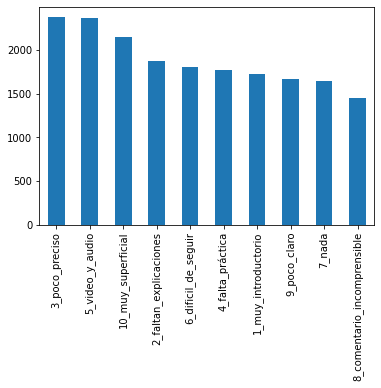

In [194]:
ax = df_dominant_topic['Dominant_Topic'].value_counts().plot(kind='bar')
plt.show()

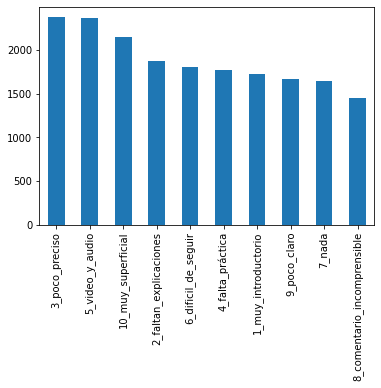

In [195]:
ax = df_news['label'].value_counts().plot(kind='bar')
plt.show()

The topis are almost balanced, so we are good

finally that we have our models set up, as well as analyzed, we can go
ahead to visualizing them.

In [196]:
import pyLDAvis

pyLDAvis.enable_notebook()

In [197]:
# %%time
import pyLDAvis.gensim
pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)

PreparedData(topic_coordinates=          x     y  topics  cluster  Freq
topic                                   
5      0.07  0.01       1        1 12.77
2     -0.04  0.02       2        1 12.53
1      0.00  0.02       3        1 11.95
4      0.12  0.09       4        1 11.52
9      0.05  0.03       5        1 11.25
6      0.14  0.03       6        1  9.85
3     -0.07  0.00       7        1  8.92
8     -0.03  0.02       8        1  7.65
0     -0.24  0.07       9        1  7.19
7     -0.00 -0.28      10        1  6.37, topic_info=            Term     Freq    Total Category  logprob  loglift
139        cosas 1,254.00 1,254.00  Default    30.00    30.00
552        audio   505.00   505.00  Default    29.00    29.00
78        videos 1,280.00 1,280.00  Default    28.00    28.00
16      explicar   798.00   798.00  Default    27.00    27.00
599    conceptos   819.00   819.00  Default    26.00    26.00
..           ...      ...      ...      ...      ...      ...
142  explicacion    58.08   921.90  Topic10    -5.25    -0.01
78        videos    58.33 1,280.12  Topic10    -5.24    -0.34
23          tema    51.72   857.27  Topic10    -5.36    -0.05
210        poder    48.57   475.64  Topic10    -5.43     0.47
150        video    48.15 1,026.54  Topic10    -5.43    -0.31

[799 rows x 6 columns], token_table=      Topic  Freq     Term
term                      
3463      9  0.95  abordan
3132     10  0.98    about
535       1  0.05    aburr
535       8  0.75    aburr
535      10  0.21    aburr
...     ...   ...      ...
151       4  0.08  youtube
151       5  0.23  youtube
151       6  0.35  youtube
151       8  0.01  youtube
151      10  0.01  youtube

[2068 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 3, 2, 5, 10, 7, 4, 9, 1, 8])

In [198]:
len(df_news),df_news.isna().sum()

(18883, index               0
 id                  0
 course              0
 rating              0
 comment             0
 user                1
 tag                 0
 comment_cleaned     0
 label               0
 label_id            0
 label_confidence    0
 dtype: int64)

In [199]:
# NOW.... GROUP BY COURSE
# AND GROUP BY LABEL THEN

In [200]:
df_by_course = df_news.groupby("course")
df_agg_by_course = pd.DataFrame(index=df_news["course"].unique())

In [201]:
df_agg_by_course["comments"] = df_by_course['comment_cleaned'].agg(sum)
df_agg_by_course.sample(10)

,comments
3217245,"[puesto, ejemplo, final, sigue, desafinado, seda, tema, warp]"
2637226,"[explicacion, amena, aprendi, conceptos, basicos, iniciarme, tecnologia, cuestion, mejorar, edicion, video, letras, veian, peque, creo, video, debiera, tener, zoom, zona, interes, toda, pantall, capitulo, numero, temprano, juzgar, complej, aqui, puedo, realmente, decir, perdi, dinero, embargo, expuesto, dejado, fascinado, bas]"
2277345,"[gustaria, clases, larg, quisiera, respuestas, tare, videos, cortan, monton, hace, pesado, repite, profesor, creo, falta, oratoria, particularmente, aport, consejos, recomendaciones, vali, ningun, material, adjunt, basico, quizas, pueda, funcionar, adolescentes, personas, experiencia, escritura, literaria, academ, abstracto, bas]"
1670644,"[presenta, edicion, contenido, presenta, manera, concisa, clara, extremadamente, bas, adquirir, conocimientos, tener, nosion, basica, qgis, terminos, incorrectos, falta, personalidad, ponent, surface, subject, insufficient, information, training]"
3265492,"[duda, gran, decepcion, pues, verdad, autor, experiencia, trata, explicar, mejor, posible, conceptos, olvido, conocimientos, podrias, frustrar, hora, armar, rigg, lleva, mencionar, siguientes, problemas, contiene, peor, falla, contiene, solo, contenido, descargable, aumenta, siguientes, problemas, sabes, usar, programas, quedar, personaje, queda, autorb, personaje, creaste, mismo, autor, querias, usar, referencia, entonces, batallar, muchisimo, rigg, conocimientos, previos, sabes, usar, programas, bases, animacion, entonces, puedes, saltar, lleno, leccion, empieza, riggear, aqui, empezaran, problemas, autor, riggea, personaje, sirven, primeras, lecciones, ningun, rigg, igual, cuentas, batallar, principiantes, puede, tiendan, frustrarsepor, cualquier, venda, plataforma, conocimiento, debe, contar, material, descargable, apoyo, flojera, alumno, quiera, hacer, contenido, sino, contando, personaje, ...]"
2426324,"[deberia, eliminado, video, confus, lleva, entera, videos, cambiados, empiezan, parte, desorden, sonido, baj, bueno, profesor, responde, preguntas, hac, audio, video, agradable, desorden, vide, eleccion, malo, escucha, bajit, opinion, conocer, temas, solo, titulos, decir, aprender, principales, cosas, hacen, malo, volumen, bajo, click, mouse, escucha, mala, diccion, logres, escuchar, dice, entiendes, arrastra, palabras, mala, explicacion, demasiados, errores, perdida, tiempo, mostrar, errores, forma, ense, hacerlo, pierde, demasiado, tiempo, buscando, error, terminen, siendo, tipo, libro, sino, libros, espero, autor, pueda, rehacer, videos, poniendole, mayor, dedicacion, cumpla, titulo, ofrec, audio, clases, extremadamente, bajo, escucha, casi, veces, escuchaba, cada, tema, volvia, crear, base, datos, explicacion, bas, ...]"
1531360,"[podria, tener, mejor, introduccion, progreso, suficiente, explicacion, empieza, directamente, pseint, malo, entiende, explica, profesor, hace, termina, siendo, confuso, vale, pen, contenido, importante, profesor, material, preparado, edita, videos, pierda, tiempo, silencios, mientras, piensa, muchisimas, muletillas, molesto, videos, enlaces, youtube, parece, revisara, videos, montarlos, plataform, pseint, vaya, usar, asidu, instructor, explica, rapido, toca, pausar, video, hac, videos, borrosos, part, basico, ejemplos, permite, consolidar, informacion, entregada, recomendable, personas, esten, comenzando, programacion, pudiera, tendria, espera, ense, arte, fundamentos, programacion, falla, crear, cimientos, solidos, videos, baja, resolucion, audio, explicaciones, pobres, sugerencia, profesor, cree, guion, apegue, prepare, mayor, detenimiento, clases, poder, ense, detenimiento, tem, termine, explica, ...]"
2851622,"[verdad, plausible, intentar, hacer, seguramente, tiempo, mejorara, falta, estructura, tematica, madurez, tabl]"
1358124,"[buena, eleccion, seria, interesante, pueda, grafico, ejemplos, ejemplo, contenedores, dock, parecer, actualizado, instalacion, actual, difiere, mostr,

In [202]:
df_agg_by_course["labels_list"] = df_by_course['label'].apply(list)
df_agg_by_course.sample(10)

,comments,labels_list
1660612,"[amat, yeterli, idea, eleg]","[1_muy_introductorio, 2_faltan_explicaciones]"
2523998,"[basico, extenso, tiempo, pocos, conceptos, explican, segundo, html, queda, termin, compartir, conocimiento, gratuitamente, sido, mucha, util, interesante, falto, parte, semantica, respecto, html, explica, basico, sinceramente, buscaba, deja, medias, ense, crear, hipervinculo, dice, haria, clase, numero, resumen, podria, mejor, complet, conocimientos, basicos, html, habria, concretar, etiquetas, innecesarias, brev, introductorio, familiarizarse, nociones, basicas, basicas, html, recomendado, ningun, tipo, conocimiento, previ]","[10_muy_superficial, 3_poco_preciso, 1_muy_introductorio, 8_comentario_incomprensible, 4_falta_práctica, 10_muy_superficial]"
2599520,"[hablo, hizo, ningun, ejercicio, nunca, nunca, mostro, hace, solo, consejosno, implementar, triste, ejemplos, solo, hablo, sector, clases, musica, temas, hac]",[6_dificil_de_seguir]
397460,"[diccion, dificil, entender, subtitulos, estan, rar, nuevo, menos, importante, aprend, gusta, gustaria, explicacion, definitivamente, informacion, sido, util, duda, ayudara, realizar, mejores, trabaj, seria, realizara, ejercicios, cada, herramientas, claro, c, eleccion, podido, descubrir, nuevas, herramientas, seran, gran, utilidad, futuro, docent, basico, programas, computacionales, docentes, profesionales, grandioso, profesionales, gusten, compartir, quedo, cort, instructor, debe, hablar, alto, alegria, monotono, hablar, profundidad, sirven, id, bastante, interesante, tendriamos, involucrarnos, enlas, diferentes, plataformas, present, parece, enfoca, demasiado, sola, opcion, quiere, mostrar, pudiese, utilizarse, navegador, solamente, firefox, gustaria, haber, visto, opciones, creacion, mapas, mentales, conceptuales, dentro, conten, parece, interesante, cuanto, proporciona, cuanto, bibliograf, lento, recomendado, personas, peque, ...]","[5_video_y_audio, 7_nada, 1_muy_introductorio, 4_falta_práctica, 4_falta_práctica, 6_dificil_de_seguir, 6_dificil_de_seguir, 3_poco_preciso, 9_poco_claro, 6_dificil_de_seguir, 1_muy_introductorio, 9_poco_claro, 4_falta_práctica, 10_muy_superficial, 6_dificil_de_seguir, 9_poco_claro, 10_muy_superficial, 10_muy_superficial, 4_falta_práctica, 2_faltan_explicaciones, 7_nada, 9_poco_claro, 9_poco_claro, 5_video_y_audio, 7_nada, 7_nada, 6_dificil_de_seguir, 10_muy_superficial, 9_poco_claro, 4_falta_práctica, 3_poco_preciso, 7_nada, 1_muy_introductorio, 2_faltan_explicaciones, 8_comentario_incomprensible, 9_poco_claro, 2_faltan_explicaciones, 1_muy_introductorio]"
1343536,"[regular, proomina, material, corto, necesario, examen, audio, contras, pesima, edicion, extienden, videos, necesario, resolver, detalles, parte, pena, ajena, imagenes, realiza, editor, verdad, mucha, risa, aditamentos, circulo, rectangulo, lapiz, valla, picazo, investigar, aparte, referente, explica, script, inicial, base, practicamente, recomiendo, solo, ofert, momento, montar, salta, parte, encontrar, un, todavia, termine, momento, creo, mejorable, conocimiento, medio, avanzado, linux, sirve, repasar, conceptos, profesor, falta, didactico, momentos, explica, resolver, problema, cada, cosa, hace, solo, sirve, aprender, comandos, entender, trasfondo, conllevan, momentos, pierde, tiempo, pantallas, carga, esperas, podria, pausar, video, adelantarlo, luego, conceptos, complicados, avanza, rap, contenido, considero, debe, mejorar, formato, utilizado, decir, concerniente, errores, ...]","[5_video_y_audio, 10_muy_superficial, 6_dificil_de_seguir, 5_video_y_audio, 3_poco_preciso, 10_muy_superficial, 2_faltan_explicaciones, 2_faltan_explicaciones, 8_comentario_incomprensible, 9_poco_claro, 2_faltan_explicaciones]"
1665144,"[autentico, desastre, profesor, organizacion, preparacion, parece, udemy, cualquiera, puede, ense, favor, controlen, organizacion, preparacion, parte, monitor, incompetente, compres, estafa, vergonzoso, udemy, permita, publiquen, sujeto, formacion, preparacion, 

In [203]:
df_agg_by_course['labels_len'] = df_agg_by_course['labels_list'].str.len()

In [204]:
df_agg_by_course.sort_values('labels_len', ascending=False).head(10)

,comments,labels_list,labels_len
1671664,"[cuenta, gratuito, cumple, objetivo, debe, recalcar, nombran, variables, tipos, forma, declararlas, adecuadamente, cualquier, modo, sirvio, aprendi, utilizar, adecuadamente, modulo, cl, siento, inconforme, indica, cero, entiendo, faltan, cosas, detalles, explicar, incompleto, youtube, buscar, mejor, darse, idea, funciona, comandos, explica, sirv, batallaba, muchisimo, entender, instructor, coincidia, cosas, decia, escribia, intentaba, interpretar, logre, recolectar, informacion, necesaria, cuestiones, conocia, realmente, basico, funciona, organizacion, temas, decepcionante, hora, entenderlo, aplicar, analiz, profesor, pronuncia, espa, cuesta, entend, estructura, deficiente, profesor, comunica, manera, flu, ense, basico, persona, confusa, explic, tono, explica, jerarquias, regul, explica, detalles, supone, principi, verdad, interes, iniciar, macros, excel, brev, buena, eleccion, perspectiva, modesta, abordaron, ...]","[2_faltan_explicaciones, 10_muy_superficial, 2_faltan_explicaciones, 10_muy_superficial, 5_video_y_audio, 2_faltan_explicaciones, 3_poco_preciso, 10_muy_superficial, 10_muy_superficial, 5_video_y_audio, 1_muy_introductorio, 1_muy_introductorio, 3_poco_preciso, 10_muy_superficial, 2_faltan_explicaciones, 3_poco_preciso, 4_falta_práctica, 8_comentario_incomprensible, 3_poco_preciso, 3_poco_preciso, 2_faltan_explicaciones, 9_poco_claro, 5_video_y_audio, 2_faltan_explicaciones, 1_muy_introductorio, 9_poco_claro, 2_faltan_explicaciones, 9_poco_claro, 6_dificil_de_seguir, 6_dificil_de_seguir, 5_video_y_audio, 5_video_y_audio, 4_falta_práctica, 10_muy_superficial, 9_poco_claro, 5_video_y_audio, 10_muy_superficial, 4_falta_práctica, 10_muy_superficial, 5_video_y_audio, 3_poco_preciso, 10_muy_superficial, 8_comentario_incomprensible, 6_dificil_de_seguir, 9_poco_claro, 2_faltan_explicaciones, 9_poco_claro, 10_muy_superficial, 10_muy_superficial, 5_video_y_audio, 5_video_y_audio, 4_falta_práctica, 4_falta_práctica, 2_faltan_explicaciones, 5_video_y_audio, 9_poco_claro, 5_video_y_audio, 5_video_y_audio, 6_dificil_de_seguir, 9_poco_claro, 6_dificil_de_seguir, 5_video_y_audio, 5_video_y_audio, 3_poco_preciso, 2_faltan_explicaciones, 3_poco_preciso, 7_nada, 6_dificil_de_seguir, 6_dificil_de_seguir, 5_video_y_audio, 2_faltan_explicaciones, 6_dificil_de_seguir, 7_nada, 2_faltan_explicaciones, 5_video_y_audio, 2_faltan_explicaciones, 5_video_y_audio, 10_muy_superficial, 2_faltan_explicaciones, 10_muy_superficial, 10_muy_superficial, 10_muy_superficial, 1_muy_introductorio, 10_muy_superficial, 5_video_y_audio, 4_falta_práctica, 3_poco_preciso, 2_faltan_explicaciones, 10_muy_superficial, 3_poco_preciso, 5_video_y_audio, 2_faltan_explicaciones, 3_poco_preciso, 8_comentario_incomprensible, 5_video_y_audio, 10_muy_superficial, 1_muy_introductorio, 9_poco_claro, 3_poco_preciso, 9_poco_claro, ...]",152
1218500,"[califican, tareas, usuarios, quejan, certific, materiales, podrian, mejores, hace, dinam, corrigen, tareas, imposible, terminar, obtener, certificado, finalizacion, momento, requiere, trabajo, subtitulacion, bastan, subtitulos, automat, dificil, entender, instructor, dice, musica, hace, dificil, comprend, poca, claridad, id, formato, poner, imagenes, clases, presenciales, grabadas, agrega, valor, sido, mejor, tener, material, mejor, calidad, profesor, necesario, mostrar, grabacion, distrae, sum, calidad, contenido, debajo, standard, clase, grab, falta, explicacion, aplicada, etap, eleccion, cuesta, entender, espa, profesor, musica, calidad, video, puede, mejorar, guias, aportan, verdadero, valor, cada, tem, alguien, recien, comenzando, aprender, metodologia, scrum, podria, entregar, infromacion, quitar, musica, fond, eleccion, arrepiento, tarde, inicie, pedir, reembolso, grabacion, ...]","[4_falta_práctica, 5_video_y_audio, 10_muy_superficial, 7_nada, 5_video_y_audio, 5_video_y_audio, 6_dificil_de_seguir, 1_muy_introductorio, 1_muy_introductorio, 5_video_y_audio, 5_video_y_audio, 2_faltan_

In [205]:
df_agg_by_course.to_csv("udemy_reviews_aggregated.csv.zip", 
           index=False, 
           compression="zip")

try:
    shutil.copy('udemy_reviews_aggregated.csv.zip', udemy_folder + '/udemy_reviews_aggregated.csv.zip')
except:
    pass

In [206]:
labels_expanded = df_agg_by_course["labels_list"].apply(pd.Series)


In [207]:
df_agg_by_course["labels_list"].head()

1640654                                                                                            [8_comentario_incomprensible]
88380                                                                            [9_poco_claro, 5_video_y_audio, 3_poco_preciso]
126128                                                                                                            [9_poco_claro]
2307340    [6_dificil_de_seguir, 7_nada, 7_nada, 1_muy_introductorio, 3_poco_preciso, 6_dificil_de_seguir, 9_poco_claro, 7_nada]
3517622                                                                                                       [4_falta_práctica]
Name: labels_list, dtype: object

,10_muy_superficial,1_muy_introductorio,2_faltan_explicaciones,3_poco_preciso,4_falta_práctica,5_video_y_audio,6_dificil_de_seguir,7_nada,8_comentario_incomprensible,9_poco_claro
2017212,9,17,7,16,11,10,3,7,7,11
1317138,14,15,3,21,7,11,6,6,8,9
2258224,6,15,5,19,13,3,3,6,6,8
935680,7,14,15,9,9,7,7,6,5,4
405252,14,14,6,8,8,4,5,8,13,5


,1_muy_introductorio,2_faltan_explicaciones,3_poco_preciso,4_falta_práctica,5_video_y_audio,6_dificil_de_seguir,7_nada,8_comentario_incomprensible,9_poco_claro,10_muy_superficial
1_muy_introductorio,112.95,49.94,55.54,69.60,50.46,57.05,50.94,46.98,41.99,48.88
2_faltan_explicaciones,49.94,86.00,47.25,59.28,43.67,47.04,40.11,37.33,34.75,39.85
3_poco_preciso,55.54,47.25,99.85,56.72,46.40,50.55,46.49,41.55,35.35,45.51
4_falta_práctica,69.60,59.28,56.72,135.97,59.09,68.41,57.64,47.82,48.95,54.42
5_video_y_audio,50.46,43.67,46.40,59.09,90.87,51.19,41.68,38.53,35.03,41.82
6_dificil_de_seguir,57.05,47.04,50.55,68.41,51.19,130.12,52.91,45.92,42.84,43.24
7_nada,50.94,40.11,46.49,57.64,41.68,52.91,93.74,41.46,35.05,42.13
8_comentario_incomprensible,46.98,37.33,41.55,47.82,38.53,45.92,41.46,76.58,30.26,35.72
9_poco_claro,41.99,34.75,35.35,48.95,35.03,42.84,35.05,30.26,66.52,33.13
10_muy_superficial,48.88,39.85,45.51,54.42,41.82,43.24,42.13,35.72,33.13,81.40


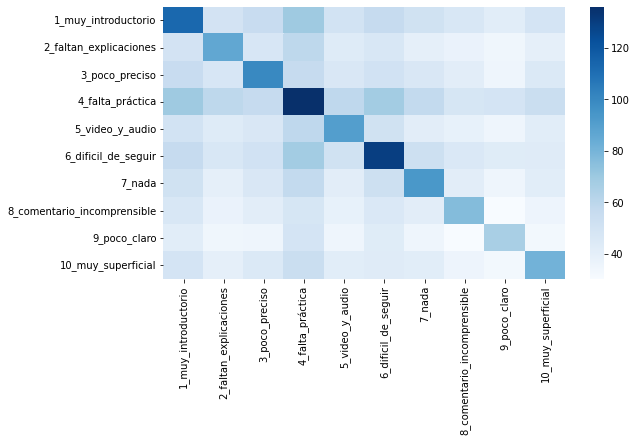

In [214]:
import itertools
import numpy as np

class MultiLabelCounter():
    def __init__(self, classes=None):
        self.classes_ = classes

    def fit(self,y):
        self.classes_ = sorted(set(itertools.chain.from_iterable(y)))
        self.mapping = dict(zip(self.classes_,
                                         range(len(self.classes_))))
        return self

    def transform(self,y):
        yt = []
        for labels in y:
            data = [0]*len(self.classes_)
            for label in labels:
                data[self.mapping[label]] +=1
            yt.append(data)
        return yt

    def fit_transform(self,y):
        return self.fit(y).transform(y)

    
mlc = MultiLabelCounter()
df = pd.DataFrame(mlc.fit_transform(df_agg_by_course["labels_list"]),
                          columns=mlc.classes_,
                          index=df_agg_by_course.index)

###################
df = df[df.sum(axis=1)>3]
display(df.sort_values("1_muy_introductorio",ascending=False).head())

###################
from sklearn.preprocessing import Normalizer
normalizeddf_train = Normalizer().fit_transform(df)
normalizeddf_train = pd.DataFrame(normalizeddf_train, columns = df.columns, index = df.index)
normalizeddf_train

fruits_corr = normalizeddf_train.corr(method = "pearson")
fruits_freq_mat = np.dot(normalizeddf_train.T, normalizeddf_train)
fruits_freq = pd.DataFrame(fruits_freq_mat, columns = label_dicc.values(), index = label_dicc.values())
display(fruits_freq)

###################
import seaborn as sn
fig, ax = plt.subplots(figsize = (9,5))
sn.heatmap(fruits_freq, cmap = "Blues")
plt.xticks(rotation=90)
plt.savefig("heatmap.png", dpi = 300)


In [215]:
display(normalizeddf_train.sort_values("1_muy_introductorio",ascending=False).head())

,10_muy_superficial,1_muy_introductorio,2_faltan_explicaciones,3_poco_preciso,4_falta_práctica,5_video_y_audio,6_dificil_de_seguir,7_nada,8_comentario_incomprensible,9_poco_claro
1294804,0.00,0.97,0.00,0.00,0.00,0.24,0.00,0.00,0.00,0.00
1779130,0.00,0.92,0.23,0.23,0.23,0.00,0.00,0.00,0.00,0.00
717524,0.28,0.83,0.28,0.00,0.00,0.28,0.00,0.00,0.28,0.00
2347082,0.00,0.83,0.00,0.28,0.28,0.28,0.00,0.28,0.00,0.00
1410468,0.41,0.82,0.00,0.00,0.00,0.00,0.00,0.00,0.41,0.00


In [220]:
df.loc[1779130]

10_muy_superficial             0
1_muy_introductorio            4
2_faltan_explicaciones         1
3_poco_preciso                 1
4_falta_práctica               1
5_video_y_audio                0
6_dificil_de_seguir            0
7_nada                         0
8_comentario_incomprensible    0
9_poco_claro                   0
Name: 1779130, dtype: int64

In [219]:
# por ejeeeemplo

df_news[df_news["course"]==1779130]

,index,id,course,rating,comment,user,tag,comment_cleaned,label,label_id,label_confidence
4214,37938,93759838,1779130,2.50,"Falto llevarlo a la practica, desde mi punto de vista este un curso muy teórico, falto realizar uno o dos ejercicios y para que despues se explique la solución, el por que se utilizo cada uno de los objetos entre otras cosas.",Armando Martinez,neg,"[falto, llevarlo, practica, punto, vista, teorico, falto, realizar, ejercicios, despues, explique, solucion, utilizo, cada, objetos, c]",1_muy_introductorio,0,0.50
4215,37956,65706292,1779130,1.00,"El audio es de mala calidad, descuidado y con errores\nEl material presentado es descuidado en presentación, organización, pareciera reciclado de algún webinar\nEl contenido es muy básico y superficial para considerarse un curso con el valor que se comenta (sin descuento), como si se tratara de un webinar introductorio o una platica introductoria para alumnos de universidad",Jesus Alvarado Bastida,neg,"[audio, mala, calidad, descuidado, erroresel, material, presentado, descuidado, presentacion, organizacion, pareciera, reciclado, algun, webinarel, contenido, basico, superficial, considerarse, valor, comenta, descuento, tratara, webinar, introductorio, platica, introductoria, alumnos, univers]",1_muy_introductorio,0,0.48
4216,37957,65063996,1779130,3.00,Falta ejemplos prácticos para trabajar con el usuario.,Diana Margot Palpa Grande,neg,"[falta, ejemplos, practicos, trabajar, usuari]",1_muy_introductorio,0,0.85
4217,37963,60073956,1779130,3.00,"Me gustaría que tuviera ejercicios prácticos y pruebas evaluatorias de seleccion simple, que se compruebe que uno si hizo el curso más que solo ver los videos",Mariana Villa,neg,"[gustaria, ejercicios, practicos, pruebas, evaluatorias, seleccion, simple, compruebe, hizo, solo, vide]",4_falta_práctica,3,0.49
4218,37970,56617014,1779130,3.50,"Es muy teorico, no hay mucha practica. Sin embargo el contenido es muy bueno.",Edinson,neg,"[teorico, mucha, practica, embargo, conten]",3_poco_preciso,2,0.85
4219,37986,34234790,1779130,3.50,Va muy lento. Falta profundizar en ejemplos,Cindy Fonseca,neg,"[lento, falta, profundizar, ejempl]",1_muy_introductorio,0,0.82
4220,37987,33337000,1779130,3.50,"Me gustó el curso. Sería interesante agregar una sección final para que se puedan corroborar los ejercicios de práctica en, al menos una posible solución.",FluxIT. SA,neg,"[gusto, seria, interesante, agregar, seccion, final, puedan, corroborar, ejercicios, practica, menos, posible, solucion]",2_faltan_explicaciones,1,0.75
